In [314]:
import os
import sys
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns

# Allow imports from project dir
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.Wordle import Wordle

In [209]:
bowcur

{'0': {'a': 0.06090712742980561,
  'b': 0.07473002159827213,
  'c': 0.08552915766738661,
  'd': 0.04794816414686825,
  'e': 0.031101511879049675,
  'f': 0.05874730021598272,
  'g': 0.04967602591792657,
  'h': 0.029805615550755938,
  'i': 0.01468682505399568,
  'j': 0.008639308855291577,
  'k': 0.008639308855291577,
  'l': 0.03801295896328294,
  'm': 0.04622030237580994,
  'n': 0.015982721382289417,
  'o': 0.017710583153347732,
  'p': 0.061339092872570194,
  'q': 0.009935205183585313,
  'r': 0.04535637149028078,
  's': 0.15809935205183584,
  't': 0.06436285097192225,
  'u': 0.014254859611231102,
  'v': 0.018574514038876888,
  'w': 0.035853131749460046,
  'x': 0.0,
  'y': 0.002591792656587473,
  'z': 0.0012958963282937365},
 '1': {'a': 0.13131749460043196,
  'b': 0.006911447084233261,
  'c': 0.017278617710583154,
  'd': 0.008639308855291577,
  'e': 0.10453563714902808,
  'f': 0.0034557235421166306,
  'g': 0.005183585313174946,
  'h': 0.06220302375809935,
  'i': 0.08725701943844492,
  'j'

In [211]:
def calc_ll(word_list, bow, colname):
    """    
    Calculate log-likelihood of word from Letter Frequency given in a bag of words 5x26 matrix 
        see BJA-01.2-make-word-lists
    """
    result = []
    for word in word_list:
        likelihood = 0
        for i, letter in enumerate(word):
            # Add 1/2315 to do a Laplace estimate, to prevent likelihoods from going to zero
            likelihood += np.log(bow[str(i)][letter] + (1/2315))
        result.append((word, likelihood))
    return pd.DataFrame(sorted(result, key=lambda x: x[1], reverse=True), columns=['w', colname]).set_index('w') 


def total_green_letter_prob(word, bow):
    # Finds total probability that you will get at least 1 green in any position by testing this word
    prob = 0
    for i, letter in enumerate(word):
        prob += bow[str(i)][letter]
    return prob

def prob_of_2_greens(word):
    # How do you calculate this? 
    pass

def total_yellow_letter_prob(word):
    prob = 0 
    
    
# Allow for repeat letters with max_repeats
def contains_repeats(word, search, max_repeats):
    s = set(letter for letter in search)
    repeats = 0
    for letter in word:
        if letter in s:
            repeats += 1
    if repeats <= max_repeats:
        return False
    else:
        return True

In [212]:
# word list with frequencies
wl = pd.read_csv(r'..\data\processed\wordle_google_freq_word_list.csv', index_col=0)
alphabet = 'abcdefghijklmnopqrstuvwxyz'
# Read in  Bags of Letters matrices (AKA bag-of-words = bow) 
with open(r'..\data\processed\bags_of_words.json', 'r') as infile:
    all_bow = json.load(infile, parse_int=False)
bow17 = all_bow['combined_wordle_google']
bowwordle = all_bow['all_wordle']
bowcur = all_bow['wordle_curated']

bow17lfl = calc_lfl(wl.index, bow17, colname='all')
bowwordlelfl = calc_lfl(wl.loc[wl['in_wordle']].index, bowwordle, colname='wordle')
bowcurlfl = calc_lfl(wl.loc[wl['in_wordle_curated']].index, bowcur, colname='curated')

lfl = pd.concat([bow17lfl, bowwordlelfl, bowcurlfl], axis=1, sort=True)
# lfl.to_csv(r'..\data\processed\letter_freq_likelihoods.csv')

## Question:

## What sequence of words provides the highest chance of finding greens and yellows, while also not repeating any letters (i.e. maximizing grays)? 

### Make a function that iterates through the top 200 words with highest letter-frequency probability and finds the sequence of 5 words that has no repeats 
### If it can't find a next word with no repeat, then take the word with just one repeat (i.e. len(set(word)) == 4) 
### Then sum the calculated letter-freq probabilities of all the words 

### This will give a probability of finding a green but it doesn't include the helpful contribution from simply covering more letters and finding more grays. 
### To account for grays, include a "if you have X gray letter, what % of words are excluded?"

## Important! The dataset for this optimization must use the entire wordle list, but with their letter-freq probabilities calculated from the curated list. 

## Then use the top 200 from curated as starting points for the calculation.

In [213]:
data = wl.loc[wl['in_wordle'], ['in_wordle_curated']]
data['wll'] = calc_ll(data.index, bowcur, colname='wll')   # wlh = Word Likelihood from letter frequency

# tglp = Total Green Letter Probability
# sum of all probabilities of finding that letter in that position 
data['tglp'] = data.index.map(lambda x: total_green_letter_prob(x, bow=bowcur)) 
curated_sorted = data.sort_values(['in_wordle_curated', 'tglp'], ascending=False)
curated_words = curated_sorted.loc[curated_sorted['in_wordle_curated']].index
display(curated_words)
data = data.sort_values('tglp', ascending=False)
data['unique_letters'] = data.index.map(lambda x: len(set(x)))
data.head(10)

Index(['slate', 'sauce', 'slice', 'shale', 'saute', 'share', 'sooty', 'shine',
       'suite', 'crane',
       ...
       'lymph', 'jumbo', 'igloo', 'ethic', 'unzip', 'umbra', 'affix', 'ethos',
       'inbox', 'nymph'],
      dtype='object', name='w', length=2315)

,in_wordle_curated,wll,tglp,unique_letters
w,,,,
saree,False,-10.193005,0.680346,4
sooey,False,-10.029327,0.678618,4
soree,False,-10.278527,0.669546,4
saine,False,-10.261327,0.666091,5
soare,False,-10.383047,0.660043,5
saice,False,-10.440375,0.653132,5
sease,False,-10.407718,0.652268,3
seare,False,-10.524775,0.644060,4
seine,False,-10.488578,0.639309,4


In [244]:
def contains_repeats(word, search, max_repeats):
    # Allow for repeat letters with max_repeats
    s = set(letter for letter in search)
    repeats = 0
    for letter in word:
        if letter in s:
            repeats += 1
    if repeats <= max_repeats:
        return False
    else:
        return True

def calc_summed_tglp_and_repeats(sequence):
    repeats = set()
    pos_dict = {0: [], 1: [], 2: [], 3: [], 4: []}
    tglp = 0
    for word in sequence:
        for i, letter in enumerate(word):
            repeats.add(letter)
            if letter not in pos_dict[i]:
                tglp += bowcur[str(i)][letter]
            pos_dict[i].append(letter)
    return tglp, len(repeats)

def calc_tll_and_repeats(sequence):
    repeats = set()
    tll = 0
    for word in sequence:
        tll += data.loc[word, 'wll']
        for i, letter in enumerate(word):
            repeats.add(letter)
    return tll, len(repeats)
    
def check_word(word, pos_dict, combined_words, max_num_repeats_prev_guesses, max_num_repeats_next_guess):
    """
    Optimize the guess sequence search algorithm with following conditions:
    1. Do not repeat letters previously guessed (maximize letter information based on grays/yellows/greens)
    2. Next guess should maximize number of new letters, up to max_num_repeats_next_guess
    3. If you must guess with repeat letters, do not repeat letters in the same position as before
    
    Perform these tests with word list ranked by TGLP, and again ranked by word likelihood. 
    
    Return True if the word being tested meets all 3 conditions
    
    word: string
    pos_dict: dict of index: list of letters used in this position
    combined_words: string of combined words in sequence
    max_num_repeat_prev_guesses: int of maximum number of repeat letters allowed from previous guesses
    max_num_repeats_next_guess: int of maximum number of repeat letters allowed in next guess
    """
    
    # Check for condition #3
    for i, letter in enumerate(word):
        if letter in pos_dict[i]:
            return False
    
    # Check condition #2, that the word doesn't repeat too many letters
    if not len(set(word)) >= (5 - max_num_repeats_next_guess):
        return False
    
    # Check for condition #1: do not repeat letters previously guessed
        # if contains_repeats returns True, then it contains repeats which is bad, so return False
        # if contains_repeats returns False, then within tolerance, the word is good
        # Therefore return the opposite of contains_repeats()
    return not contains_repeats(word, combined_words, max_repeats=max_num_repeats_prev_guesses)   

def add_to_pos_dict(word, pos_dict):
    for i, letter in enumerate(word):
        pos_dict[i].append(letter)
    return pos_dict

In [63]:
# Test cases
test_sequence = ['saint', 'cored', 'bulky', 'whomp']
print(calc_summed_tglp_and_repeats(test_sequence))

print(contains_repeats('saint', 'qdghy', 0)) # does not contain any repeats, so False
print(contains_repeats('saint', 'adghy', 0)) # does contain a repeat (letter 'a') so return True
print(contains_repeats('saint', 'adghy', 1)) # contains 1 repeat, which is within tolerance, so return False

(1.698488120950324, 19)
False
True
False


In [288]:
# start_words_list = data.loc[data['in_wordle_curated']].index
# results = []

# List of tuples of (number of repeats from previous guesses, number of repeats in next guess)
# Increment each one, corresponding with a looser search tolerance
priority_list = [(0, 0), (1, 0), (1, 1), (2, 1), (3, 1), (4, 1), (3, 2)]

def guess_sequence_search(word_list, word_value, results, priority_list):
    """
    word_list: list of words in ranked order biggest to smallest, same as word_value
    word_value: list of word's values
    results: list to append to
    priority_list: priority ranking for check_word() function 
    """
    for start_word in word_list:
        if len(set(start_word)) < 4:  # Skip words that only have 3 unique letters
            continue
        combined_words = start_word
    #     summed_tglp = data.loc[start_word, 'tglp']
        sequence = [start_word]
        pos_dict = {0: [], 1: [], 2: [], 3: [], 4: []}
        pos_dict = add_to_pos_dict(start_word, pos_dict)

        # Iterate until the sequence is filled with 4 words beyond start_word, or priority_list runs out
        for _ in range(4):
            # Non-recursive implementation
            for test_word, tglp in zip(words, word_value): 
                if check_word(test_word, pos_dict, combined_words, priority_list[0][0], priority_list[0][1]):
                    sequence.append(test_word)
                    pos_dict = add_to_pos_dict(test_word, pos_dict)
                    combined_words += test_word
                    break
                if test_word == words[-1]:
                    for test_word, tglp in zip(words, word_value):
                        if check_word(test_word, pos_dict, combined_words, priority_list[1][0], priority_list[1][1]):
                            sequence.append(test_word)
                            pos_dict = add_to_pos_dict(test_word, pos_dict)
                            combined_words += test_word
                            break
                        if test_word == words[-1]:
                            for test_word, tglp in zip(words, word_value):
                                if check_word(test_word, pos_dict, combined_words, priority_list[2][0], priority_list[2][1]):
                                    sequence.append(test_word)
                                    pos_dict = add_to_pos_dict(test_word, pos_dict)
                                    combined_words += test_word
                                    break
                                if test_word == words[-1]:
                                    for test_word, tglp in zip(words, word_value):
                                        if check_word(test_word, pos_dict, combined_words, priority_list[3][0], priority_list[3][1]):
                                            sequence.append(test_word)
                                            pos_dict = add_to_pos_dict(test_word, pos_dict)
                                            combined_words += test_word
                                            break
                                        if test_word == words[-1]:
                                            for test_word, tglp in zip(words, word_value):
                                                if check_word(test_word, pos_dict, combined_words, priority_list[4][0], priority_list[4][1]):
                                                    sequence.append(test_word)
                                                    pos_dict = add_to_pos_dict(test_word, pos_dict)
                                                    combined_words += test_word
                                                    break
                                                if test_word == words[-1]:
                                                    for test_word, tglp in zip(words, word_value):
                                                        if check_word(test_word, pos_dict, combined_words, priority_list[5][0], priority_list[5][1]):
                                                            sequence.append(test_word)
                                                            pos_dict = add_to_pos_dict(test_word, pos_dict)
                                                            combined_words += test_word
                                                            break     
                                                        if test_word == words[-1]:
                                                            for test_word, tglp in zip(words, word_value):
                                                                if check_word(test_word, pos_dict, combined_words, priority_list[6][0], priority_list[6][1]):
                                                                    sequence.append(test_word)
                                                                    pos_dict = add_to_pos_dict(test_word, pos_dict)
                                                                    combined_words += test_word
                                                                    break   
        results.append(sequence)
        print(sequence)
    return results

In [304]:
tglp_data = data.sort_values('tglp', ascending=False)
tglp_words = tglp_data.index
tglp_list = tglp_data['tglp'].to_list()
tglp_results = []

tglp_results = guess_sequence_search(word_list=tglp_words,
                                     word_value=tglp_list,
                                     results=tglp_results, 
                                     priority_list=priority_list)

['saree', 'bliny', 'chout', 'gramp', 'fjeld']
['sooey', 'brant', 'child', 'flump', 'gawks']
['soree', 'gaily', 'bundt', 'whack', 'frump']
['saine', 'borty', 'pluck', 'hewgh', 'fumed']
['soare', 'bliny', 'dutch', 'frump', 'gawks']
['saice', 'drony', 'flump', 'bight', 'wokka']
['seare', 'bliny', 'chout', 'faded', 'gopak']
['seine', 'coaly', 'brugh', 'tapet', 'fjord']
['slane', 'pricy', 'fouth', 'baked', 'gemma']
['soole', 'briny', 'chapt', 'fumed', 'gawks']
['siree', 'coaly', 'bundt', 'whomp', 'griff']
['soote', 'briny', 'cauld', 'khaph', 'gemma']
['slate', 'crony', 'guimp', 'vozhd', 'wauff']
['soily', 'crane', 'bumph', 'fated', 'wigga']
['soave', 'briny', 'mulct', 'hewgh', 'faded']
['samey', 'point', 'brugh', 'flack', 'dewax']
['sauce', 'briny', 'plotz', 'hewgh', 'domed']
['slice', 'praty', 'bound', 'hewgh', 'kamik']
['seame', 'crony', 'built', 'vozhd', 'qapik']
['souse', 'briny', 'clapt', 'hewgh', 'faded']
['cooey', 'saint', 'brugh', 'dwalm', 'pukka']
['shale', 'crony', 'putid', 'begem

KeyboardInterrupt: 

In [ ]:
df = []
for sequence in tglp_results:
    df.append((*sequence, 
               *calc_summed_tglp_and_repeats(sequence),
               *calc_summed_tglp_and_repeats(sequence[:-1]),
               *calc_summed_tglp_and_repeats(sequence[:-2]), 
               *calc_summed_tglp_and_repeats(sequence[:-3])))
    

columns = ['w1', 'w2', 'w3', 'w4', 'w5', 
           'tglp5', 'nu5', 
           'tglp4', 'nu4',
           'tglp3', 'nu3',
           'tglp2', 'nu2']
df = pd.DataFrame(df, columns=columns)
for num in ['2', '3', '4', '5']:
    df['mean_tglp'+num] = df['tglp'+num]/(int(num) * 5)
    df['mean_tglp_per_unique'+num] = df['tglp'+num]/df['nu'+num]
# tglp# = total green letter probability with that many words in the sequence
# nu# = Number of Unique letters in that sequence 
# mean_tglp# = average Total green letter probability gained per letter (not unique letter!!)
df

In [307]:
for num in ['2', '3', '4', '5']:
    df['mean_tglp'+num] = df['tglp'+num]/(int(num) * 5)

In [308]:
df

,w1,w2,w3,w4,w5,tglp5,nu5,tglp4,nu4,tglp3,...,tglp2,nu2,mean_tglp2,mean_tglp_per_unique2,mean_tglp3,mean_tglp_per_unique3,mean_tglp4,mean_tglp_per_unique4,mean_tglp5,mean_tglp_per_unique5
0,saree,bliny,chout,gramp,fjeld,2.198704,20,1.941685,17,1.590497,...,1.192657,9,0.119266,0.132517,0.106033,0.113607,0.097084,0.114217,0.087948,0.109935
1,sooey,brant,child,flump,gawks,2.074730,21,1.843197,18,1.572786,...,1.189201,9,0.118920,0.132133,0.104852,0.112342,0.092160,0.102400,0.082989,0.098797
2,soree,gaily,bundt,whack,frump,2.190929,21,1.892009,18,1.546868,...,1.192657,9,0.119266,0.132517,0.103125,0.110491,0.094600,0.105112,0.087637,0.104330
3,saine,borty,pluck,hewgh,fumed,2.075162,21,1.721382,18,1.482937,...,1.149028,10,0.114903,0.114903,0.098862,0.098862,0.086069,0.095632,0.083006,0.098817
4,soare,bliny,dutch,frump,gawks,2.004752,21,1.773218,18,1.474298,...,1.172354,10,0.117235,0.117235,0.098287,0.098287,0.088661,0.098512,0.080190,0.095464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12502,hypha,slice,front,dumky,bewig,1.792657,21,1.516199,18,1.180562,...,0.713175,9,0.071317,0.079242,0.078704,0.084326,0.075810,0.084233,0.071706,0.085365
12503,enzym,slart,hoick,budge,jiffy,1.707559,21,1.428510,19,1.025054,...,0.645356,10,0.064536,0.064536,0.068337,0.068337,0.071425,0.075185,0.068302,0.081312
12504,emmys,brant,could,weigh,zappy,1.684233,20,1.347732,18,0.999568,...,0.601296,9,0.060130,0.066811,0.066638,0.071398,0.067387,0.074874,0.067369,0.084212
12505,umphs,crane,doily,beget,skoff,1.938229,20,1.644060,18,1.189201,...,0.678618,10,0.067862,0.067862,0.079280,0.079280,0.082203,0.091337,0.077529,0.096911


In [290]:
print('Best 1st word guess according to TGLP:')
print(data['tglp'].idxmax())
for num in ['2','3','4','5']:
    best = df['mean_tglp_per_unique'+num].idxmax()
    print(f'Best {num}-word sequence according to TGLP:')
    print(df.loc[best, ['w1', 'w2', 'w3', 'w4', 'w5']].to_list()[:int(num)])

Best 1st word guess according to TGLP:
saree
Best 2-word sequence according to TGLP:
['seine', 'coaly']
Best 3-word sequence according to TGLP:
['poupt', 'saine', 'clary']
Best 4-word sequence according to TGLP:
['aurae', 'soily', 'chant', 'faded']
Best 5-word sequence according to TGLP:
['looie', 'saury', 'chant', 'bided', 'primp']


In [306]:
# df.to_csv(r'..\data\processed\TGLP_word_sequences.csv')
df = pd.read_csv(r'..\data\processed\TGLP_word_sequences.csv', index_col=0)
df

,w1,w2,w3,w4,w5,tglp5,nu5,tglp4,nu4,tglp3,...,tglp2,nu2,mean_tglp2,mean_tglp_per_unique2,mean_tglp3,mean_tglp_per_unique3,mean_tglp4,mean_tglp_per_unique4,mean_tglp5,mean_tglp_per_unique5
0,saree,bliny,chout,gramp,fjeld,2.198704,20,1.941685,17,1.590497,...,1.192657,9,0.596328,0.132517,0.530166,0.113607,0.485421,0.114217,0.439741,0.109935
1,sooey,brant,child,flump,gawks,2.074730,21,1.843197,18,1.572786,...,1.189201,9,0.594600,0.132133,0.524262,0.112342,0.460799,0.102400,0.414946,0.098797
2,soree,gaily,bundt,whack,frump,2.190929,21,1.892009,18,1.546868,...,1.192657,9,0.596328,0.132517,0.515623,0.110491,0.473002,0.105112,0.438186,0.104330
3,saine,borty,pluck,hewgh,fumed,2.075162,21,1.721382,18,1.482937,...,1.149028,10,0.574514,0.114903,0.494312,0.098862,0.430346,0.095632,0.415032,0.098817
4,soare,bliny,dutch,frump,gawks,2.004752,21,1.773218,18,1.474298,...,1.172354,10,0.586177,0.117235,0.491433,0.098287,0.443305,0.098512,0.400950,0.095464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12502,hypha,slice,front,dumky,bewig,1.792657,21,1.516199,18,1.180562,...,0.713175,9,0.356587,0.079242,0.393521,0.084326,0.379050,0.084233,0.358531,0.085365
12503,enzym,slart,hoick,budge,jiffy,1.707559,21,1.428510,19,1.025054,...,0.645356,10,0.322678,0.064536,0.341685,0.068337,0.357127,0.075185,0.341512,0.081312
12504,emmys,brant,could,weigh,zappy,1.684233,20,1.347732,18,0.999568,...,0.601296,9,0.300648,0.066811,0.333189,0.071398,0.336933,0.074874,0.336847,0.084212
12505,umphs,crane,doily,beget,skoff,1.938229,20,1.644060,18,1.189201,...,0.678618,10,0.339309,0.067862,0.396400,0.079280,0.411015,0.091337,0.387646,0.096911


In [303]:
df

,w1,w2,w3,w4,w5,tglp5,nu5,tglp4,nu4,tglp3,...,tglp2,nu2,mean_tglp2,mean_tglp_per_unique2,mean_tglp3,mean_tglp_per_unique3,mean_tglp4,mean_tglp_per_unique4,mean_tglp5,mean_tglp_per_unique5
0,saree,bliny,chout,gramp,fjeld,2.198704,20,1.941685,17,1.590497,...,1.192657,9,0.596328,0.132517,0.530166,0.113607,0.485421,0.114217,0.439741,0.109935
1,sooey,brant,child,flump,gawks,2.074730,21,1.843197,18,1.572786,...,1.189201,9,0.594600,0.132133,0.524262,0.112342,0.460799,0.102400,0.414946,0.098797
2,soree,gaily,bundt,whack,frump,2.190929,21,1.892009,18,1.546868,...,1.192657,9,0.596328,0.132517,0.515623,0.110491,0.473002,0.105112,0.438186,0.104330
3,saine,borty,pluck,hewgh,fumed,2.075162,21,1.721382,18,1.482937,...,1.149028,10,0.574514,0.114903,0.494312,0.098862,0.430346,0.095632,0.415032,0.098817
4,soare,bliny,dutch,frump,gawks,2.004752,21,1.773218,18,1.474298,...,1.172354,10,0.586177,0.117235,0.491433,0.098287,0.443305,0.098512,0.400950,0.095464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12502,hypha,slice,front,dumky,bewig,1.792657,21,1.516199,18,1.180562,...,0.713175,9,0.356587,0.079242,0.393521,0.084326,0.379050,0.084233,0.358531,0.085365
12503,enzym,slart,hoick,budge,jiffy,1.707559,21,1.428510,19,1.025054,...,0.645356,10,0.322678,0.064536,0.341685,0.068337,0.357127,0.075185,0.341512,0.081312
12504,emmys,brant,could,weigh,zappy,1.684233,20,1.347732,18,0.999568,...,0.601296,9,0.300648,0.066811,0.333189,0.071398,0.336933,0.074874,0.336847,0.084212
12505,umphs,crane,doily,beget,skoff,1.938229,20,1.644060,18,1.189201,...,0.678618,10,0.339309,0.067862,0.396400,0.079280,0.411015,0.091337,0.387646,0.096911


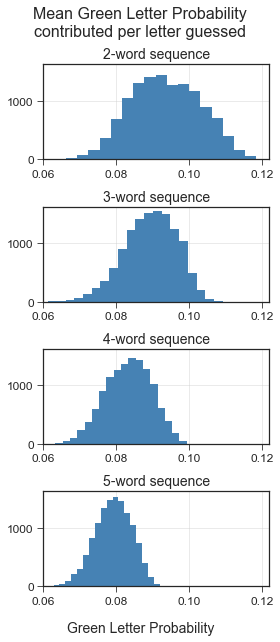

In [316]:
fig, ax = plt.subplots(nrows=4, sharey=True)
for i, num in enumerate(['2', '3', '4', '5']):
    ax[i].hist(df['mean_tglp'+num], bins=20, color='steelblue')
    ax[i].set_title(f'{num}-word sequence', fontsize=14)
    ax[i].set_xlim((0.06, 0.122))
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].grid(alpha=0.5)
fig.set_size_inches((4, 9))
fig.suptitle('Mean Green Letter Probability\ncontributed per letter guessed', fontsize=16)
fig.supxlabel('Green Letter Probability', fontsize=14)

fig.tight_layout()

# plt.savefig(r'..\reports\figures\mean_GLP_per_letter.svg')


In [325]:
df

,w1,w2,w3,w4,w5,tglp5,nu5,tglp4,nu4,tglp3,...,tglp2,nu2,mean_tglp2,mean_tglp_per_unique2,mean_tglp3,mean_tglp_per_unique3,mean_tglp4,mean_tglp_per_unique4,mean_tglp5,mean_tglp_per_unique5
0,saree,bliny,chout,gramp,fjeld,2.198704,20,1.941685,17,1.590497,...,1.192657,9,0.119266,0.132517,0.106033,0.113607,0.097084,0.114217,0.087948,0.109935
1,sooey,brant,child,flump,gawks,2.074730,21,1.843197,18,1.572786,...,1.189201,9,0.118920,0.132133,0.104852,0.112342,0.092160,0.102400,0.082989,0.098797
2,soree,gaily,bundt,whack,frump,2.190929,21,1.892009,18,1.546868,...,1.192657,9,0.119266,0.132517,0.103125,0.110491,0.094600,0.105112,0.087637,0.104330
3,saine,borty,pluck,hewgh,fumed,2.075162,21,1.721382,18,1.482937,...,1.149028,10,0.114903,0.114903,0.098862,0.098862,0.086069,0.095632,0.083006,0.098817
4,soare,bliny,dutch,frump,gawks,2.004752,21,1.773218,18,1.474298,...,1.172354,10,0.117235,0.117235,0.098287,0.098287,0.088661,0.098512,0.080190,0.095464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12502,hypha,slice,front,dumky,bewig,1.792657,21,1.516199,18,1.180562,...,0.713175,9,0.071317,0.079242,0.078704,0.084326,0.075810,0.084233,0.071706,0.085365
12503,enzym,slart,hoick,budge,jiffy,1.707559,21,1.428510,19,1.025054,...,0.645356,10,0.064536,0.064536,0.068337,0.068337,0.071425,0.075185,0.068302,0.081312
12504,emmys,brant,could,weigh,zappy,1.684233,20,1.347732,18,0.999568,...,0.601296,9,0.060130,0.066811,0.066638,0.071398,0.067387,0.074874,0.067369,0.084212
12505,umphs,crane,doily,beget,skoff,1.938229,20,1.644060,18,1.189201,...,0.678618,10,0.067862,0.067862,0.079280,0.079280,0.082203,0.091337,0.077529,0.096911


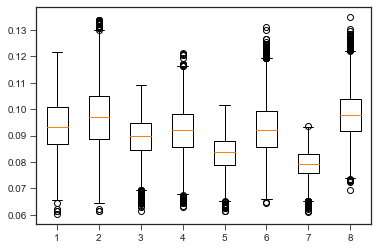

In [324]:
# for i, num in enumerate(['2','3','4','5']):
plt.boxplot(df.filter(regex='mean_tglp'));

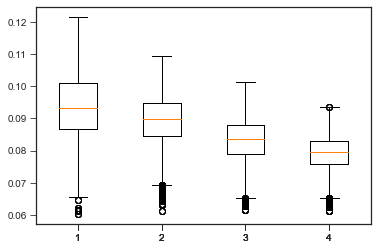

In [334]:
fig, ax = plt.subplots()

for i, num in enumerate(['2','3','4','5']):
    ax.boxplot(df[['mean_tglp2', 'mean_tglp3', 'mean_tglp4', 'mean_tglp5']])

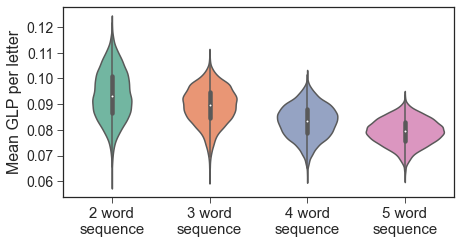

In [362]:
sns.violinplot(data=df[['mean_tglp2', 'mean_tglp3', 'mean_tglp4', 'mean_tglp5']], 
               palette=sns.color_palette('Set2', desat=1))

# plt.title('Mean Green Letter Probability\ncontributed per letter guessed')
plt.xticks([0,1,2,3], labels=['2 word\nsequence', '3 word\nsequence', 
                              '4 word\nsequence', '5 word\nsequence'], fontsize=15)
plt.yticks(fontsize=14)
plt.ylabel('Mean GLP per letter', fontsize=16)

plt.gcf().set_size_inches((7, 3.5))

plt.savefig(r'..\reports\figures\mean_GLP_per_letter.svg')


# Same thing for log-likelihood of words instead of TGLP

In [297]:
ll_data = data.sort_values('wll', ascending=False)
ll_words = ll_data.index
ll_list = ll_data['wll'].to_list()
ll_results = []

ll_results = guess_sequence_search(word_list=ll_words,
                                     word_value=ll_list,
                                     results=ll_results, 
                                     priority_list=priority_list)

['sooey', 'brant', 'child', 'flump', 'gawks']
['saree', 'bliny', 'chout', 'gramp', 'fjeld']
['saine', 'borty', 'pluck', 'hewgh', 'fumed']
['soree', 'gaily', 'bundt', 'whack', 'frump']
['soare', 'bliny', 'dutch', 'frump', 'gawks']
['saice', 'drony', 'flump', 'bight', 'wokka']
['seine', 'coaly', 'brugh', 'tapet', 'fjord']
['seare', 'bliny', 'chout', 'faded', 'gopak']
['slane', 'pricy', 'fouth', 'baked', 'gemma']
['soole', 'briny', 'chapt', 'fumed', 'gawks']
['siree', 'coaly', 'bundt', 'whomp', 'griff']
['soily', 'crane', 'bumph', 'fated', 'wigga']
['cooey', 'saint', 'brugh', 'dwalm', 'pukka']
['soote', 'briny', 'cauld', 'khaph', 'gemma']
['saint', 'corey', 'flump', 'hewgh', 'kibbe']
['slate', 'crony', 'guimp', 'vozhd', 'wauff']
['slier', 'coady', 'thunk', 'gamme', 'bebop']
['saist', 'corey', 'blunk', 'whomp', 'fidge']
['slice', 'praty', 'bound', 'hewgh', 'kamik']
['sooty', 'crane', 'build', 'whump', 'gaffs']
['crane', 'soily', 'bumph', 'fated', 'wigga']
['souse', 'briny', 'clapt', 'hewgh

['maare', 'soily', 'bundt', 'chowk', 'gruff']
['boast', 'crine', 'plumy', 'hewgh', 'faded']
['poney', 'slart', 'quich', 'badge', 'mekka']
['savey', 'point', 'brugh', 'flack', 'dewax']
['prole', 'saint', 'fudgy', 'whack', 'bemix']
['chase', 'briny', 'poult', 'faded', 'skegg']
['bialy', 'souce', 'print', 'hewgh', 'faded']
['cruse', 'gaily', 'month', 'bided', 'spazz']
['snare', 'doily', 'butch', 'frump', 'gawks']
['salty', 'crine', 'bough', 'piped', 'flamm']
['blate', 'shiny', 'frock', 'muxed', 'gawps']
['sheer', 'coaly', 'quint', 'badge', 'frump']
['maise', 'crony', 'gulph', 'skatt', 'boded']
['sunny', 'coate', 'whirl', 'faded', 'grump']
['sored', 'gaily', 'chunk', 'tempt', 'buffe']
['trite', 'soapy', 'clunk', 'hewgh', 'faded']
['soave', 'briny', 'mulct', 'hewgh', 'faded']
['raise', 'pouty', 'clank', 'hewgh', 'bided']
['meane', 'soily', 'cruft', 'paged', 'kheth']
['brast', 'coney', 'guild', 'whomp', 'jeffs']
['teary', 'slink', 'pouch', 'badge', 'immew']
['bliny', 'soare', 'dutch', 'frump

['flier', 'soapy', 'bundt', 'chowk', 'gamme']
['farse', 'bliny', 'chout', 'domed', 'spazz']
['silly', 'crane', 'fouth', 'paged', 'bemix']
['trait', 'souce', 'glyph', 'djinn', 'baffy']
['dooce', 'slaty', 'brink', 'whump', 'gaffs']
['goosy', 'crane', 'built', 'whump', 'faded']
['clint', 'soare', 'pudgy', 'bimah', 'wauff']
['prese', 'coaly', 'quint', 'hewgh', 'faded']
['parae', 'soily', 'bundt', 'whack', 'gruff']
['slimy', 'crane', 'fouth', 'paged', 'kebab']
['doily', 'sauce', 'brant', 'whomp', 'vuggs']
['sluit', 'crane', 'podgy', 'whiff', 'vibex']
['stire', 'coaly', 'bundh', 'frump', 'gawks']
['point', 'samey', 'brugh', 'flack', 'dewax']
['chary', 'suite', 'blond', 'kopek', 'maxim']
['parle', 'shiny', 'doubt', 'crack', 'gemma']
['shoed', 'briny', 'claut', 'pogge', 'kamik']
['cense', 'fairy', 'boult', 'whomp', 'gived']
['moony', 'saice', 'blurt', 'khaph', 'gived']
['prune', 'soily', 'chaft', 'baked', 'gemma']
['curet', 'soily', 'bhang', 'damme', 'pluff']
['sooth', 'crane', 'blimy', 'puked

['phare', 'soily', 'bundt', 'crock', 'maxim']
['beray', 'suint', 'flock', 'whump', 'gadge']
['crest', 'gaily', 'bound', 'whomp', 'quaff']
['curer', 'soily', 'thank', 'badge', 'frump']
['carat', 'soily', 'bunde', 'whomp', 'graff']
['moory', 'saine', 'pluck', 'bight', 'fedex']
['plant', 'souce', 'grimy', 'faded', 'bekah']
['feint', 'soapy', 'brugh', 'clock', 'damme']
['chant', 'soily', 'brume', 'faded', 'wigga']
['meaty', 'slink', 'broch', 'pudge', 'wauff']
['slink', 'coate', 'druxy', 'bumph', 'gaffs']
['spier', 'coaly', 'bundt', 'hewgh', 'kamme']
['looie', 'saury', 'chant', 'bided', 'primp']
['wrate', 'soily', 'chunk', 'faded', 'bebop']
['curie', 'slaty', 'pownd', 'brogh', 'mekka']
['leone', 'saury', 'thick', 'boded', 'gramp']
['alant', 'souce', 'primy', 'hewgh', 'faded']
['shunt', 'brace', 'doily', 'kamik', 'wigga']
['troat', 'slice', 'bungy', 'whump', 'faded']
['prost', 'faine', 'bludy', 'whack', 'gemma']
['blist', 'crane', 'podgy', 'muzak', 'fifth']
['torte', 'saucy', 'blind', 'whomp

['crape', 'soily', 'bundt', 'hewgh', 'kamik']
['sloth', 'crane', 'pudgy', 'bemix', 'wauff']
['stint', 'brace', 'godly', 'whump', 'jeffs']
['shape', 'crony', 'built', 'faded', 'gemma']
['senor', 'gaily', 'butch', 'domed', 'pluff']
['taunt', 'soily', 'perch', 'budge', 'flamm']
['stele', 'crony', 'faugh', 'biped', 'muzak']
['moist', 'crane', 'bludy', 'hewgh', 'skoff']
['swale', 'crony', 'bight', 'fumed', 'qapik']
['silen', 'praty', 'cough', 'damme', 'whiff']
['taler', 'shiny', 'pubco', 'dodge', 'flamm']
['weary', 'suint', 'block', 'vozhd', 'gamme']
['erose', 'gaily', 'bundt', 'whack', 'pouff']
['peage', 'soily', 'brunt', 'chowk', 'faded']
['chuse', 'briny', 'ploat', 'faded', 'skegg']
['cheer', 'soily', 'gaunt', 'buffe', 'dwaum']
['fritt', 'slane', 'choky', 'muxed', 'bebop']
['tater', 'soily', 'chunk', 'budge', 'flamm']
['samel', 'crony', 'whipt', 'budge', 'koffs']
['catty', 'shine', 'proul', 'boded', 'flamm']
['dealt', 'shiny', 'brock', 'flump', 'jaggs']
['cored', 'slaty', 'guimp', 'known

['alure', 'shiny', 'compt', 'faded', 'bewig']
['palsy', 'crine', 'fouth', 'bided', 'skegg']
['trail', 'souce', 'nymph', 'baddy', 'gliff']
['sture', 'coaly', 'brink', 'whomp', 'faded']
['goner', 'slaty', 'quich', 'damme', 'bebop']
['denet', 'soily', 'brach', 'flump', 'gawks']
['cripe', 'slaty', 'bound', 'hewgh', 'kamik']
['react', 'soily', 'bundh', 'gamme', 'pluff']
['firie', 'slaty', 'bound', 'chimp', 'gawks']
['riant', 'souce', 'glyph', 'baddy', 'frizz']
['seeld', 'crony', 'baith', 'flump', 'gowks']
['brach', 'soily', 'fumet', 'known', 'gadge']
['tally', 'souce', 'brink', 'whomp', 'gived']
['snort', 'maile', 'pudgy', 'whack', 'vibex']
['poler', 'saint', 'fudgy', 'whack', 'jembe']
['citer', 'soapy', 'blunk', 'whiff', 'gadge']
['patsy', 'crine', 'bough', 'dwalm', 'skoff']
['panel', 'brosy', 'thick', 'fudge', 'mezzo']
['crapy', 'shine', 'boult', 'faded', 'muzak']
['swile', 'crony', 'ghaut', 'boded', 'kamik']
['cosie', 'praty', 'blunk', 'whiff', 'gaged']
['boody', 'saine', 'cruft', 'whelk

['creme', 'soily', 'gaunt', 'khaph', 'bided']
['winey', 'slart', 'pouch', 'badge', 'frizz']
['baith', 'souce', 'drony', 'flamm', 'wigga']
['beset', 'coaly', 'prink', 'fudge', 'maxim']
['blady', 'souce', 'print', 'hewgh', 'kamik']
['fiery', 'slant', 'pouch', 'badge', 'muzak']
['trial', 'souce', 'nymph', 'baddy', 'quaff']
['scaly', 'brine', 'fouth', 'paged', 'muzak']
['dhole', 'saint', 'curvy', 'begem', 'pouff']
['donsy', 'crate', 'whilk', 'flump', 'vibex']
['gouty', 'saine', 'brach', 'fjeld', 'kempt']
['crout', 'saine', 'glyph', 'boded', 'femmy']
['pursy', 'coate', 'blind', 'hewgh', 'skoff']
['speer', 'coaly', 'quint', 'hewgh', 'damme']
['poult', 'saine', 'braky', 'cwtch', 'meved']
['coude', 'slaty', 'brink', 'whomp', 'gaffs']
['super', 'coaly', 'think', 'badge', 'meffs']
['shout', 'crane', 'blimy', 'faded', 'gopak']
['trill', 'soave', 'cundy', 'whomp', 'befog']
['beaut', 'soily', 'cronk', 'whump', 'fadge']
['motet', 'saury', 'clink', 'hewgh', 'buffe']
['manly', 'souce', 'brith', 'piped

['pheer', 'soily', 'gaunt', 'crack', 'buffe']
['mater', 'soily', 'chunk', 'budge', 'pizza']
['brack', 'soily', 'fumet', 'hewgh', 'panne']
['cully', 'saine', 'broth', 'domed', 'pluff']
['punny', 'soare', 'clift', 'hewgh', 'baked']
['flame', 'shiny', 'court', 'paged', 'kebab']
['clear', 'shiny', 'doubt', 'gamme', 'quaff']
['ceder', 'soily', 'gaunt', 'bumph', 'viffs']
['patty', 'slice', 'brond', 'muzak', 'hewgh']
['solan', 'trice', 'pudgy', 'chawk', 'bemix']
['pored', 'slaty', 'chink', 'begum', 'wauff']
['derry', 'saint', 'block', 'whump', 'graff']
['perst', 'coaly', 'duing', 'shmek', 'wauff']
['brond', 'saice', 'fluty', 'khaph', 'gemma']
['rorty', 'saine', 'pluck', 'hewgh', 'bided']
['thrae', 'soily', 'crunk', 'faded', 'weamb']
['wanle', 'soupy', 'chirt', 'bided', 'flamm']
['morel', 'saint', 'pudgy', 'whack', 'bluff']
['crick', 'slane', 'pouty', 'hewgh', 'faded']
['bitsy', 'crane', 'mould', 'phizz', 'skoff']
['drent', 'soily', 'gauch', 'buffe', 'whomp']
['snail', 'corey', 'bumph', 'twixt

['voile', 'saury', 'chant', 'bided', 'muzak']
['croon', 'slate', 'pudgy', 'whift', 'bobak']
['baled', 'shiny', 'court', 'gimme', 'quaff']
['shock', 'brane', 'fluty', 'gived', 'maxim']
['smite', 'coaly', 'grund', 'wheep', 'baffs']
['shoon', 'crate', 'blimy', 'puked', 'wauff']
['fosse', 'briny', 'claut', 'whomp', 'gaged']
['brume', 'soily', 'chant', 'faded', 'wigga']
['blurt', 'saine', 'choky', 'domed', 'graff']
['ghast', 'crine', 'blowy', 'fumed', 'qapik']
['crudy', 'saine', 'plotz', 'hewgh', 'bobak']
['chime', 'slaty', 'brond', 'pouff', 'gawks']
['blank', 'souce', 'primy', 'wheft', 'gaged']
['covet', 'saury', 'blind', 'whomp', 'graff']
['bated', 'soily', 'crunk', 'whomp', 'quaff']
['stall', 'crine', 'podgy', 'bumph', 'wauff']
['albee', 'shiny', 'court', 'gramp', 'fjeld']
['blain', 'souce', 'grypt', 'whiff', 'dazed']
['while', 'soapy', 'brunt', 'caged', 'muzak']
['maill', 'souce', 'grypt', 'bundh', 'fezzy']
['traik', 'souce', 'glyph', 'djinn', 'baffy']
['chest', 'briny', 'woald', 'flump

['whole', 'saint', 'crudy', 'begem', 'quaff']
['morat', 'slice', 'bungy', 'khaph', 'faded']
['later', 'shiny', 'pubco', 'dodge', 'flamm']
['copsy', 'brane', 'guilt', 'shmek', 'fjord']
['shend', 'coaly', 'bruit', 'gamme', 'quiff']
['orate', 'shiny', 'pluck', 'boded', 'maxim']
['caver', 'soily', 'bundt', 'whomp', 'graff']
['maneh', 'soily', 'cruft', 'budge', 'pizza']
['rouen', 'slaty', 'chimp', 'badge', 'jeffs']
['forge', 'slaty', 'chink', 'muxed', 'bebop']
['crepe', 'soily', 'gaunt', 'bided', 'whack']
['boral', 'shine', 'pudgy', 'cwtch', 'flamm']
['comte', 'saury', 'blind', 'khaph', 'wigga']
['tronk', 'saice', 'bludy', 'hewgh', 'quaff']
['clonk', 'samey', 'bruit', 'vozhd', 'quaff']
['pagle', 'shiny', 'court', 'bided', 'flamm']
['geode', 'slaty', 'brink', 'chump', 'waffs']
['cissy', 'brane', 'poult', 'whiff', 'gaged']
['sawer', 'bliny', 'chout', 'podge', 'muzak']
['puler', 'saint', 'choky', 'bodge', 'flamm']
['flash', 'crine', 'pouty', 'baked', 'gemma']
['urase', 'bliny', 'compt', 'hewgh

['lunet', 'soapy', 'brick', 'hewgh', 'damme']
['shuln', 'coate', 'primy', 'faded', 'bewig']
['sower', 'gaily', 'bundt', 'champ', 'jeffs']
['camel', 'shiny', 'grout', 'buffe', 'dewax']
['spoot', 'crane', 'blimy', 'faugh', 'doved']
['snoke', 'clary', 'whipt', 'fumed', 'biggs']
['spent', 'coaly', 'brugh', 'fiked', 'maxim']
['ravey', 'suint', 'block', 'whump', 'dodge']
['droll', 'saine', 'bufty', 'whack', 'plump']
['prove', 'slaty', 'chink', 'fumed', 'bewig']
['blond', 'saice', 'purty', 'hewgh', 'kokam']
['blive', 'soapy', 'grunt', 'chowk', 'faded']
['caulk', 'shine', 'borty', 'piped', 'flamm']
['trick', 'slane', 'podgy', 'bumph', 'wauff']
['click', 'soare', 'bunty', 'whomp', 'faded']
['paled', 'shiny', 'court', 'gimme', 'blaff']
['sapor', 'cline', 'bufty', 'vozhd', 'gemma']
['filly', 'soare', 'bundt', 'chimp', 'gawks']
['snipe', 'coaly', 'brugh', 'fated', 'muzak']
['cheek', 'soily', 'brant', 'pudge', 'maxim']
['corky', 'saine', 'flump', 'bight', 'wexed']
['drear', 'soily', 'chunk', 'tempt

['silky', 'crane', 'fouth', 'paged', 'bemix']
['scrae', 'bliny', 'fouth', 'paged', 'mujik']
['satem', 'crony', 'build', 'khaph', 'wigga']
['irate', 'sonly', 'chump', 'faded', 'bewig']
['liner', 'soapy', 'butch', 'fadge', 'whizz']
['premy', 'saint', 'could', 'hewgh', 'buffe']
['trock', 'saine', 'bludy', 'hewgh', 'quaff']
['clock', 'saine', 'purty', 'vozhd', 'begem']
['poled', 'saint', 'curvy', 'hewgh', 'flamm']
['sopor', 'faine', 'culty', 'hewgh', 'bided']
['cited', 'soapy', 'blunk', 'mhorr', 'gaffe']
['sheik', 'coaly', 'brunt', 'fadge', 'pimps']
['mille', 'soapy', 'brunt', 'chowk', 'faded']
['mincy', 'soare', 'gulph', 'twixt', 'faded']
['cosed', 'briny', 'fault', 'whomp', 'skegg']
['smart', 'coney', 'build', 'hewgh', 'qapik']
['blume', 'saint', 'corky', 'hewgh', 'piped']
['slept', 'crony', 'faugh', 'biked', 'whizz']
['glode', 'saint', 'curvy', 'whump', 'bobak']
['giust', 'crane', 'blowy', 'vozhd', 'skimp']
['trull', 'saine', 'choky', 'boded', 'flamm']
['carvy', 'shine', 'boult', 'piped

['petit', 'saury', 'clonk', 'vozhd', 'gimme']
['gland', 'souce', 'primy', 'wheft', 'vibex']
['raird', 'souce', 'glyph', 'twank', 'bevvy']
['breid', 'slaty', 'pouch', 'known', 'gamme']
['loued', 'saint', 'crapy', 'hewgh', 'buffe']
['frock', 'saine', 'bludy', 'pight', 'immew']
['minty', 'soare', 'pluck', 'whiff', 'gaged']
['boofy', 'saine', 'truck', 'dwalm', 'pight']
['caged', 'soily', 'brunt', 'whomp', 'quaff']
['spial', 'corey', 'bundt', 'hewgh', 'kamme']
['moder', 'slaty', 'chink', 'upbow', 'gaffe']
['churr', 'saine', 'blowy', 'dempt', 'graff']
['pandy', 'slice', 'broth', 'muzak', 'wigga']
['curdy', 'saine', 'plotz', 'hewgh', 'bobak']
['eensy', 'boart', 'child', 'frump', 'skegg']
['trend', 'soily', 'gauch', 'buffe', 'kempt']
['herry', 'saint', 'could', 'gimme', 'blaff']
['sears', 'bliny', 'chout', 'fadge', 'kopek']
['spill', 'crane', 'gouty', 'faded', 'bimah']
['sprat', 'coney', 'build', 'hewgh', 'kamme']
['taver', 'soily', 'chunk', 'budge', 'flamm']
['sisal', 'corey', 'bundt', 'whomp

['flisk', 'crane', 'pouty', 'hewgh', 'bided']
['urite', 'soapy', 'clonk', 'hewgh', 'faded']
['pound', 'saice', 'braky', 'filth', 'gemma']
['spike', 'coaly', 'brunt', 'hewgh', 'faded']
['tenor', 'saucy', 'whilk', 'bodge', 'flamm']
['choky', 'saine', 'blurt', 'domed', 'graff']
['fleme', 'saint', 'crudy', 'bokeh', 'wigga']
['loipe', 'saury', 'chant', 'bided', 'muzak']
['sires', 'coaly', 'bundt', 'whomp', 'gaffe']
['shiso', 'crane', 'fluty', 'boded', 'kamik']
['dogie', 'slaty', 'crunk', 'bumph', 'whiff']
['poupe', 'slaty', 'brink', 'cwtch', 'faded']
['snoep', 'clary', 'whift', 'budge', 'kamik']
['pesty', 'crank', 'build', 'whomp', 'gaffe']
['bever', 'soily', 'chant', 'pudge', 'kamik']
['seils', 'crony', 'ghaut', 'damme', 'kopek']
['purge', 'soily', 'chant', 'faded', 'bemix']
['reink', 'slaty', 'pouch', 'badge', 'immew']
['spued', 'coaly', 'brink', 'wheft', 'gamme']
['sharp', 'coney', 'built', 'fadge', 'mekka']
['flout', 'saine', 'crapy', 'vozhd', 'begem']
['cleve', 'saint', 'grody', 'bumph

['duett', 'soily', 'crank', 'whomp', 'gaffe']
['vaute', 'soily', 'crank', 'bumph', 'fifed']
['muset', 'coaly', 'brink', 'hewgh', 'pavid']
['tauon', 'slice', 'braky', 'whomp', 'doved']
['wader', 'soily', 'chunk', 'tempt', 'buffe']
['bribe', 'slaty', 'pound', 'chowk', 'maxim']
['aread', 'soily', 'chunk', 'tempt', 'gaffe']
['chivy', 'soare', 'blunt', 'faded', 'muzak']
['noint', 'samey', 'brugh', 'plack', 'fjord']
['badge', 'soily', 'prunt', 'whack', 'meffs']
['laird', 'souce', 'nymph', 'blatt', 'figgy']
['holly', 'saine', 'cruft', 'bided', 'whomp']
['sprue', 'coaly', 'think', 'faded', 'bemix']
['litre', 'soapy', 'chunk', 'faded', 'bemix']
['gamay', 'slice', 'front', 'puked', 'bhaji']
['wroke', 'slaty', 'cuing', 'vozhd', 'bebop']
['steal', 'crony', 'guimp', 'vozhd', 'blaff']
['colin', 'samey', 'brugh', 'twixt', 'fjord']
['stivy', 'crane', 'bough', 'fjeld', 'kamik']
['their', 'soapy', 'clunk', 'badge', 'frizz']
['posit', 'crane', 'bludy', 'whiff', 'skegg']
['tanky', 'slice', 'brogh', 'fumed

['cooze', 'slaty', 'brink', 'whump', 'faded']
['blunk', 'soare', 'chivy', 'dempt', 'gaffs']
['gusle', 'crony', 'baith', 'domed', 'spazz']
['swelt', 'crony', 'faugh', 'biped', 'muzak']
['guard', 'soily', 'bench', 'patte', 'immew']
['stull', 'crane', 'podgy', 'whift', 'kamik']
['sirra', 'coney', 'flump', 'thigh', 'bedad']
['moble', 'saint', 'crudy', 'khaph', 'wigga']
['taira', 'souce', 'glyph', 'known', 'bided']
['aimer', 'sonly', 'butch', 'fadge', 'phizz']
['study', 'crane', 'whilk', 'befog', 'maxim']
['clasp', 'brine', 'gouty', 'shmek', 'fjord']
['thiol', 'samey', 'crunk', 'bodge', 'quaff']
['moper', 'slaty', 'chink', 'budge', 'wauff']
['bodge', 'slaty', 'prink', 'vauch', 'immew']
['think', 'soare', 'bludy', 'capex', 'gemma']
['cinch', 'soare', 'fluty', 'paged', 'bemix']
['total', 'shine', 'crudy', 'begem', 'qapik']
['glout', 'saine', 'crapy', 'vozhd', 'bemix']
['capot', 'shine', 'burly', 'domed', 'graff']
['wrack', 'soily', 'bunde', 'pight', 'maxim']
['dined', 'slaty', 'broch', 'guimp

['woold', 'saine', 'purty', 'chack', 'begem']
['claro', 'shine', 'bufty', 'paged', 'kokam']
['haith', 'souce', 'drony', 'flamm', 'bebop']
['fraud', 'soily', 'bench', 'patte', 'muzak']
['sweed', 'coaly', 'print', 'faugh', 'jembe']
['meted', 'soily', 'crank', 'faugh', 'bizzo']
['sceat', 'briny', 'mould', 'khaph', 'gaffe']
['drook', 'saine', 'fluty', 'champ', 'bewig']
['missy', 'crane', 'boult', 'phizz', 'faded']
['mavie', 'sonly', 'cruft', 'khaph', 'bided']
['crans', 'boite', 'plumy', 'hewgh', 'faded']
['dinar', 'souce', 'glyph', 'twixt', 'baffy']
['loord', 'saine', 'bufty', 'whack', 'grump']
['muser', 'coaly', 'think', 'badge', 'pluff']
['burin', 'slate', 'choky', 'faded', 'primp']
['brize', 'slaty', 'pound', 'chowk', 'maxim']
['rider', 'slaty', 'pouch', 'known', 'gamme']
['stood', 'crane', 'blimy', 'faugh', 'kopek']
['shans', 'corey', 'built', 'fadge', 'plump']
['stend', 'coaly', 'brugh', 'flimp', 'varve']
['valse', 'crony', 'whipt', 'fumed', 'bobak']
['pilot', 'samey', 'crunk', 'vozhd

['haste', 'crony', 'build', 'swamp', 'goffs']
['souls', 'crane', 'whity', 'faded', 'bebop']
['eager', 'soily', 'bundt', 'whack', 'frump']
['sithe', 'coaly', 'grund', 'blimp', 'waffs']
['scrat', 'boney', 'guild', 'whomp', 'jeffs']
['paolo', 'shine', 'crudy', 'blatt', 'muzak']
['mover', 'slaty', 'chink', 'budge', 'wauff']
['bares', 'doily', 'chunk', 'tempt', 'graff']
['mussy', 'crane', 'doilt', 'hewgh', 'skoff']
['swear', 'bliny', 'chout', 'fadge', 'kopek']
['sepad', 'crony', 'built', 'howff', 'gamme']
['heath', 'soily', 'crunk', 'badge', 'whomp']
['geeky', 'saint', 'broch', 'flump', 'doved']
['slits', 'crane', 'podgy', 'bumph', 'wauff']
['taped', 'soily', 'crunk', 'hewgh', 'buffe']
['gnarr', 'soily', 'chute', 'faded', 'bebop']
['tilde', 'soapy', 'crunk', 'whiff', 'begem']
['ruder', 'soily', 'chant', 'gamme', 'bebop']
['belch', 'saint', 'grody', 'flump', 'wokka']
['bowne', 'slaty', 'prick', 'faugh', 'meved']
['soras', 'cline', 'bufty', 'whomp', 'gaged']
['cower', 'slaty', 'duing', 'fehme

['dropt', 'saine', 'fluky', 'cwtch', 'begem']
['clang', 'suite', 'frowy', 'vozhd', 'bebop']
['spumy', 'crane', 'doilt', 'hewgh', 'vibex']
['borna', 'slice', 'pudgy', 'wheft', 'kamik']
['shyly', 'crane', 'quoit', 'boded', 'flimp']
['todde', 'saury', 'clink', 'bumph', 'graff']
['suits', 'crane', 'blowy', 'vozhd', 'kamik']
['aesir', 'pouty', 'clank', 'whiff', 'badge']
['elain', 'soupy', 'crwth', 'badge', 'muzak']
['dries', 'coaly', 'thunk', 'gamme', 'bebop']
['slung', 'coate', 'primy', 'faded', 'bekah']
['fiver', 'slaty', 'bound', 'chimp', 'gawks']
['coria', 'shule', 'banty', 'piped', 'flamm']
['paced', 'soily', 'brunt', 'hewgh', 'flamm']
['bores', 'gaily', 'chunk', 'dempt', 'quaff']
['druid', 'slane', 'choky', 'tempt', 'vibex']
['horme', 'slaty', 'cuing', 'faded', 'bebop']
['manky', 'slice', 'broth', 'fuzed', 'wigga']
['scody', 'brane', 'guilt', 'whump', 'koffs']
['maron', 'slice', 'bufty', 'vozhd', 'wigga']
['slots', 'crane', 'pudgy', 'whift', 'bobak']
['toped', 'saury', 'clink', 'hewgh

['swack', 'brine', 'pouty', 'fjeld', 'might']
['mulct', 'saine', 'grody', 'khaph', 'vibex']
['folky', 'saine', 'brugh', 'dempt', 'wicca']
['gavel', 'shiny', 'court', 'buffe', 'dwalm']
['tares', 'bliny', 'pouch', 'fidge', 'muzak']
['mensh', 'coaly', 'bruit', 'fadge', 'swizz']
['crons', 'maile', 'bufty', 'vozhd', 'skegg']
['faena', 'soily', 'truck', 'bumph', 'wedge']
['hired', 'slaty', 'quonk', 'bocce', 'primp']
['dural', 'shine', 'boxty', 'crack', 'plump']
['tinea', 'surly', 'chowk', 'badge', 'primp']
['chara', 'soily', 'bunde', 'kempt', 'wauff']
['hasty', 'crine', 'mould', 'spazz', 'bewig']
['souts', 'crane', 'blimy', 'hewgh', 'faded']
['spend', 'coaly', 'bruit', 'whiff', 'gamme']
['beans', 'pricy', 'moult', 'fadge', 'chowk']
['prief', 'slaty', 'bound', 'chowk', 'gamme']
['chevy', 'saint', 'proul', 'bodge', 'flamm']
['swive', 'coaly', 'brunt', 'humph', 'faded']
['wider', 'slaty', 'pouch', 'mange', 'frizz']
['dicer', 'slaty', 'bough', 'known', 'primp']
['crura', 'soily', 'pwned', 'bight

['tains', 'corey', 'flump', 'hewgh', 'kibbe']
['monad', 'slice', 'purty', 'hewgh', 'vibex']
['homer', 'slaty', 'cuing', 'pavid', 'kibbe']
['tawny', 'slice', 'brogh', 'fumed', 'koppa']
['beton', 'saury', 'child', 'pogge', 'flamm']
['fauna', 'soily', 'crept', 'hewgh', 'bided']
['cling', 'soare', 'bufty', 'whomp', 'dazed']
['leech', 'saint', 'grody', 'flump', 'bobak']
['smaak', 'crine', 'pouty', 'fjeld', 'hewgh']
['dungy', 'soare', 'clipt', 'bimah', 'wauff']
['furth', 'saine', 'blowy', 'crack', 'domed']
['arced', 'soily', 'thunk', 'gamme', 'blaff']
['cools', 'brane', 'whity', 'fumed', 'skegg']
['quate', 'soily', 'cronk', 'whump', 'faded']
['homie', 'slaty', 'crunk', 'faded', 'bebop']
['rusty', 'faine', 'block', 'whump', 'doved']
['reccy', 'saint', 'bough', 'dwalm', 'pukka']
['ceria', 'sonly', 'bumph', 'twixt', 'fadge']
['tryer', 'saick', 'blond', 'whump', 'foggy']
['ardor', 'slice', 'bunty', 'whomp', 'gaffs']
['cubed', 'soily', 'grant', 'whomp', 'jeffs']
['scaur', 'boite', 'glyph', 'known

['plica', 'shone', 'druxy', 'motet', 'bewig']
['sorda', 'cline', 'bufty', 'whomp', 'jaggs']
['amene', 'soily', 'cruft', 'khaph', 'gaged']
['fecit', 'soapy', 'grund', 'whilk', 'jambe']
['towie', 'saury', 'clank', 'bumph', 'gived']
['sabes', 'crony', 'guilt', 'whump', 'vodka']
['losed', 'briny', 'chapt', 'muzak', 'gaffe']
['chica', 'sonly', 'brute', 'faded', 'kempt']
['verst', 'coaly', 'duing', 'whomp', 'kibbe']
['aargh', 'soily', 'bunce', 'dempt', 'viffs']
['sorgo', 'faine', 'culty', 'whomp', 'bided']
['eider', 'slaty', 'pouch', 'known', 'gamme']
['punky', 'soare', 'clift', 'hewgh', 'bided']
['rieve', 'slaty', 'bound', 'chimp', 'gawks']
['sutra', 'coney', 'whilk', 'badge', 'flamm']
['beins', 'coaly', 'furth', 'gadge', 'plump']
['handy', 'slice', 'grout', 'kopek', 'weamb']
['cuing', 'soare', 'lymph', 'batty', 'fifed']
['saims', 'corey', 'blunt', 'khaph', 'fidge']
['realo', 'shiny', 'fumet', 'bocce', 'pavid']
['presa', 'bliny', 'chout', 'fadge', 'muzak']
['stoun', 'brace', 'dimly', 'phizz

['sango', 'trice', 'bludy', 'whomp', 'quaff']
['towsy', 'crane', 'build', 'shmek', 'pluff']
['felid', 'soapy', 'brunt', 'chowk', 'gamme']
['bogan', 'slice', 'purty', 'faded', 'chawk']
['lingy', 'soare', 'butch', 'faded', 'primp']
['cecal', 'shiny', 'grout', 'damme', 'kopek']
['wries', 'coaly', 'bundt', 'gamme', 'skoff']
['porno', 'saice', 'fluty', 'hewgh', 'bided']
['hadst', 'crine', 'blowy', 'muzak', 'pouff']
['hound', 'saice', 'grypt', 'flamm', 'bevvy']
['cameo', 'shiny', 'blurt', 'podge', 'quaff']
['pinon', 'slate', 'crudy', 'whiff', 'begem']
['bales', 'crony', 'whipt', 'fudge', 'kokam']
['teddy', 'saick', 'brogh', 'flump', 'jinne']
['luted', 'soapy', 'brink', 'chuff', 'gamme']
['cacky', 'shine', 'boult', 'gramp', 'fifed']
['coots', 'brane', 'plumy', 'weigh', 'faded']
['speck', 'briny', 'fault', 'vozhd', 'gimme']
['ginch', 'soare', 'fluty', 'paved', 'bemix']
['dunsh', 'coate', 'primy', 'bluff', 'skegg']
['teres', 'coaly', 'duing', 'whomp', 'kibbe']
['fetid', 'soapy', 'crunk', 'whelm

['pairs', 'coney', 'thumb', 'fjeld', 'wigga']
['teins', 'coaly', 'brugh', 'damme', 'skoff']
['swapt', 'crine', 'godly', 'muzak', 'fifth']
['ticed', 'soapy', 'blunk', 'mhorr', 'gaffe']
['circa', 'shone', 'fluty', 'boded', 'gramp']
['jeune', 'soily', 'bract', 'whomp', 'faded']
['bowel', 'saint', 'crudy', 'khaph', 'gimme']
['sixer', 'coaly', 'bundt', 'whomp', 'gaffe']
['siker', 'coaly', 'bundt', 'whomp', 'gaffe']
['gobar', 'slice', 'punty', 'faded', 'chawk']
['plasm', 'crine', 'gouty', 'faded', 'bekah']
['paspy', 'crine', 'boult', 'hewgh', 'fumed']
['chasm', 'brine', 'pouty', 'fjeld', 'gawks']
['tommy', 'saine', 'brugh', 'plack', 'fifed']
['soaks', 'crine', 'fluty', 'bumph', 'gaged']
['dital', 'souce', 'nymph', 'graff', 'bevvy']
['felon', 'saury', 'thick', 'bodge', 'pimps']
['doven', 'slaty', 'brick', 'whump', 'gaffe']
['salts', 'crine', 'podgy', 'bumph', 'affix']
['segno', 'clary', 'whipt', 'fumed', 'bobak']
['oiler', 'saucy', 'thank', 'bodge', 'primp']
['whack', 'soily', 'prune', 'beget

['women', 'slaty', 'brick', 'pudge', 'chuff']
['grass', 'coney', 'built', 'whomp', 'dekko']
['grues', 'coaly', 'think', 'damme', 'bebop']
['frons', 'maile', 'pudgy', 'thack', 'vibex']
['apert', 'soily', 'chunk', 'badge', 'flamm']
['bonze', 'slaty', 'prick', 'faugh', 'meved']
['awner', 'soily', 'butch', 'fadge', 'plump']
['cauls', 'brine', 'podgy', 'wheft', 'muzak']
['sizer', 'coaly', 'bundt', 'whomp', 'gaffe']
['dores', 'gaily', 'chunk', 'tempt', 'buffe']
['gryce', 'saint', 'mould', 'khaph', 'bevvy']
['smeke', 'coaly', 'print', 'faugh', 'bided']
['pokey', 'saint', 'brugh', 'dwalm', 'cezve']
['pears', 'bliny', 'chout', 'fadge', 'muzak']
['munch', 'soare', 'fitly', 'paged', 'whizz']
['pians', 'corey', 'thumb', 'fjeld', 'swizz']
['heuch', 'soily', 'brant', 'fadge', 'whomp']
['huger', 'soily', 'twank', 'damme', 'cloff']
['tates', 'crony', 'build', 'whump', 'skegg']
['turfy', 'saine', 'block', 'whump', 'doved']
['bayed', 'suint', 'frock', 'whelp', 'moggy']
['whilk', 'soare', 'bunty', 'caged

['verge', 'soily', 'chant', 'fumed', 'qapik']
['gofer', 'slaty', 'chink', 'bemud', 'pizza']
['becke', 'soily', 'grant', 'whump', 'faded']
['curio', 'slane', 'bawty', 'vozhd', 'primp']
['aeons', 'pricy', 'thumb', 'fjeld', 'wokka']
['dowie', 'slaty', 'crunk', 'bumph', 'gaffs']
['smush', 'crane', 'doily', 'tapet', 'bewig']
['glift', 'soare', 'cundy', 'whomp', 'vibex']
['outre', 'shaly', 'boink', 'caged', 'frump']
['tuyer', 'saick', 'blond', 'whump', 'foggy']
['musar', 'coney', 'glift', 'khaph', 'debud']
['pudgy', 'saine', 'croft', 'whelk', 'bemix']
['cowed', 'slaty', 'brink', 'faugh', 'pimps']
['apeek', 'soily', 'brunt', 'chaff', 'gadge']
['rakee', 'soily', 'bundt', 'champ', 'gruff']
['proas', 'cline', 'bufty', 'vozhd', 'skegg']
['baels', 'crony', 'whipt', 'fudge', 'kokam']
['aweel', 'shiny', 'court', 'badge', 'flamm']
['moong', 'saice', 'truly', 'khaph', 'bided']
['carom', 'shine', 'fluty', 'boded', 'wigga']
['tubar', 'soily', 'dench', 'gamme', 'pluff']
['towel', 'saury', 'chink', 'budge

['tacky', 'shine', 'proul', 'boded', 'flamm']
['wrang', 'soily', 'chute', 'faded', 'bebop']
['nooky', 'saice', 'blurt', 'hewgh', 'piped']
['shuls', 'crane', 'boxty', 'gived', 'flimp']
['coses', 'briny', 'fault', 'whomp', 'kedge']
['dedal', 'shiny', 'court', 'gamme', 'blaff']
['stoop', 'crane', 'blimy', 'faugh', 'doved']
['figgy', 'soare', 'blunt', 'chimp', 'waded']
['femal', 'shiny', 'court', 'badge', 'pukka']
['anted', 'soily', 'brugh', 'clack', 'maxim']
['feats', 'crony', 'build', 'whump', 'skegg']
['rough', 'saine', 'platy', 'crock', 'bided']
['tiars', 'coney', 'flump', 'hewgh', 'kabob']
['wolve', 'saint', 'crudy', 'bumph', 'jeffs']
['cebid', 'slaty', 'pronk', 'faugh', 'whizz']
['milch', 'soare', 'bunty', 'faded', 'phizz']
['ripen', 'slaty', 'cough', 'damme', 'frizz']
['mails', 'corey', 'bundt', 'khaph', 'gruff']
['scran', 'boite', 'plumy', 'hewgh', 'faded']
['potes', 'briny', 'cauld', 'hewgh', 'flamm']
['tanto', 'slice', 'druxy', 'bumph', 'gowks']
['netty', 'saick', 'brogh', 'flump

['hiply', 'soare', 'bundt', 'crick', 'maxim']
['baurs', 'coney', 'glift', 'whomp', 'dekko']
['bison', 'crate', 'plumy', 'vozhd', 'skiff']
['bhuna', 'soily', 'crept', 'fadge', 'muzak']
['meved', 'soily', 'brant', 'gauch', 'pukka']
['lawer', 'shiny', 'compt', 'budge', 'jeffs']
['mairs', 'coney', 'gulph', 'skatt', 'bedad']
['waddy', 'slice', 'front', 'bumph', 'giver']
['fuddy', 'saine', 'broch', 'welkt', 'plump']
['ducat', 'soily', 'kreng', 'whomp', 'blaff']
['naled', 'soupy', 'chirt', 'gimme', 'blaff']
['pigmy', 'soare', 'blunt', 'chowk', 'faded']
['payed', 'suint', 'broch', 'flamm', 'wiggy']
['quilt', 'soare', 'chynd', 'baggy', 'frump']
['wares', 'bliny', 'chout', 'podge', 'muzak']
['gilpy', 'soare', 'bundt', 'chowk', 'frizz']
['sixty', 'crane', 'bough', 'flimp', 'waded']
['jaunt', 'soily', 'perch', 'budge', 'flamm']
['welch', 'saint', 'grody', 'flump', 'bobak']
['flyte', 'saick', 'brond', 'whump', 'vuggy']
['ancle', 'soupy', 'brith', 'faded', 'muzak']
['morra', 'slice', 'bunty', 'khaph

['crags', 'boite', 'plumy', 'nudzh', 'skoff']
['bidon', 'slate', 'curvy', 'whomp', 'griff']
['gates', 'crony', 'build', 'whump', 'affix']
['chias', 'boney', 'trump', 'fjeld', 'wigga']
['kerry', 'saint', 'could', 'bumph', 'graff']
['jerry', 'saint', 'could', 'bumph', 'graff']
['shags', 'crine', 'pouty', 'fjeld', 'kamik']
['bites', 'coaly', 'grund', 'whomp', 'skiff']
['aleft', 'shiny', 'brock', 'pudge', 'maxim']
['reais', 'pouty', 'clink', 'badge', 'wheft']
['capul', 'shine', 'borty', 'meved', 'graff']
['pocky', 'saine', 'blurt', 'hewgh', 'fumed']
['genes', 'coaly', 'bruit', 'whomp', 'skiff']
['quirt', 'slane', 'choky', 'boded', 'frump']
['reins', 'coaly', 'bumph', 'fadge', 'klett']
['riced', 'slaty', 'bough', 'known', 'primp']
['bromo', 'saine', 'fluty', 'whack', 'doped']
['mason', 'trice', 'bludy', 'khaph', 'sowff']
['alias', 'corey', 'bundt', 'whomp', 'gaffe']
['thorp', 'saine', 'bludy', 'crack', 'gemma']
['tusky', 'crane', 'bovid', 'flimp', 'hewgh']
['jinne', 'slaty', 'broch', 'fumed

['karat', 'soily', 'bunce', 'whomp', 'gived']
['tases', 'crony', 'build', 'whump', 'skegg']
['chaos', 'brine', 'fluty', 'paged', 'muzak']
['bodes', 'clary', 'quint', 'whomp', 'gaffe']
['duans', 'corey', 'glift', 'whomp', 'kibbe']
['pauls', 'crine', 'boxty', 'hewgh', 'fumed']
['sords', 'faine', 'culty', 'whomp', 'vibex']
['basso', 'crine', 'fluty', 'whomp', 'doved']
['chics', 'brane', 'pouty', 'fjeld', 'kamik']
['silts', 'crane', 'podgy', 'bumph', 'wauff']
['wedgy', 'saint', 'broch', 'flump', 'quake']
['oldie', 'saury', 'chant', 'begem', 'frizz']
['groom', 'saine', 'fluty', 'whack', 'boded']
['soums', 'crane', 'whity', 'fjeld', 'bebop']
['mates', 'crony', 'build', 'khaph', 'sowff']
['gloop', 'saine', 'crudy', 'fowth', 'bemix']
['hayer', 'suint', 'block', 'podge', 'femmy']
['neafe', 'soily', 'truck', 'bumph', 'gaged']
['doors', 'faine', 'culty', 'whump', 'skegg']
['resin', 'coaly', 'bumph', 'twixt', 'fadge']
['press', 'coaly', 'quint', 'hewgh', 'damme']
['shiva', 'corey', 'blunt', 'fadge

['brags', 'coney', 'quilt', 'whomp', 'dekko']
['skied', 'coaly', 'brunt', 'whomp', 'gaffe']
['witch', 'soare', 'bludy', 'prink', 'maxim']
['erven', 'soily', 'chapt', 'budge', 'kamik']
['cuppy', 'saine', 'broth', 'dwalm', 'goffs']
['rived', 'slaty', 'pouch', 'known', 'gamme']
['almah', 'souce', 'briny', 'tapet', 'fjord']
['unity', 'soare', 'block', 'whump', 'faded']
['comes', 'briny', 'fault', 'khaph', 'wedge']
['hoyle', 'saint', 'crump', 'bided', 'fuggy']
['derby', 'saint', 'pouch', 'flamm', 'wigga']
['tepid', 'saury', 'clonk', 'whiff', 'bombe']
['ruing', 'slate', 'choky', 'boded', 'frump']
['nutty', 'soare', 'child', 'begem', 'qapik']
['folio', 'samey', 'brunt', 'whack', 'pudge']
['hinky', 'soare', 'mulct', 'faded', 'bebop']
['boric', 'slane', 'pudgy', 'whift', 'mekka']
['algin', 'souce', 'praty', 'whiff', 'baked']
['pupal', 'shine', 'borty', 'crack', 'faded']
['tiles', 'crony', 'faugh', 'bombe', 'spazz']
['tetra', 'soily', 'chunk', 'badge', 'flamm']
['sands', 'corey', 'built', 'whomp

['sarks', 'coney', 'built', 'whomp', 'fidge']
['rifer', 'slaty', 'bound', 'chimp', 'gawks']
['etape', 'soily', 'crunk', 'hewgh', 'faded']
['colls', 'brane', 'whity', 'fumed', 'skegg']
['glias', 'corey', 'bundt', 'whomp', 'affix']
['thesp', 'coaly', 'brink', 'fudge', 'maxim']
['darns', 'boite', 'plumy', 'whack', 'affix']
['bedes', 'coaly', 'print', 'faugh', 'muzak']
['thars', 'coney', 'build', 'gamme', 'skoff']
['weals', 'crony', 'bight', 'fumed', 'kopje']
['feyed', 'saint', 'broch', 'plume', 'wiggy']
['pewit', 'saury', 'clonk', 'vozhd', 'gimme']
['ruggy', 'saine', 'cloth', 'boded', 'frump']
['legal', 'shiny', 'court', 'damme', 'blaff']
['dinna', 'souce', 'grypt', 'whilk', 'baffy']
['guars', 'coney', 'thilk', 'damme', 'bebop']
['recal', 'shiny', 'doubt', 'gamme', 'quaff']
['ayrie', 'souct', 'bland', 'whomp', 'faggy']
['liven', 'soapy', 'cruft', 'hewgh', 'damme']
['drawl', 'souce', 'bingy', 'kempt', 'chizz']
['viral', 'souce', 'nymph', 'twixt', 'baddy']
['lears', 'piony', 'butch', 'fadge

['brigs', 'coate', 'plumy', 'nudzh', 'skoff']
['congo', 'slate', 'primy', 'fuzed', 'bekah']
['waits', 'corey', 'blunk', 'humph', 'fidge']
['morph', 'saine', 'fluty', 'crack', 'bided']
['theft', 'soily', 'crank', 'budge', 'plump']
['poker', 'slaty', 'cuing', 'damme', 'wheft']
['souks', 'crane', 'blimy', 'wheft', 'paged']
['ghees', 'coaly', 'print', 'bemud', 'skoff']
['flung', 'soare', 'chivy', 'dempt', 'bawks']
['login', 'samey', 'cruft', 'khaph', 'bedad']
['clags', 'brine', 'pouty', 'shmek', 'fjord']
['theta', 'soily', 'crunk', 'badge', 'flamm']
['agone', 'shily', 'cruft', 'boded', 'kamik']
['pokie', 'slaty', 'grund', 'chimb', 'waffs']
['colog', 'saine', 'purty', 'bided', 'whack']
['saddo', 'crine', 'fluty', 'bumph', 'gowks']
['skirr', 'coate', 'bludy', 'whomp', 'ganef']
['arets', 'bliny', 'pouch', 'fadge', 'muzak']
['salvo', 'crine', 'bufty', 'whomp', 'doxed']
['hough', 'saine', 'crypt', 'dwalm', 'bevvy']
['cents', 'fairy', 'bough', 'dwalm', 'pukka']
['slugs', 'crane', 'whity', 'boked

['cells', 'briny', 'fouat', 'whomp', 'gadge']
['lotes', 'briny', 'gauch', 'swamp', 'fjord']
['murra', 'soily', 'bench', 'patte', 'gived']
['heres', 'coaly', 'quint', 'badge', 'frump']
['tumid', 'soare', 'lynch', 'baggy', 'frizz']
['quake', 'soily', 'crwth', 'baned', 'plump']
['timon', 'sauce', 'glyph', 'fjord', 'bevvy']
['coves', 'briny', 'fault', 'whomp', 'kedge']
['weils', 'crony', 'ghaut', 'damme', 'kopek']
['unsee', 'coaly', 'brith', 'pavid', 'skoff']
['urnal', 'seity', 'chowk', 'badge', 'flamm']
['gloom', 'saine', 'crudy', 'fowth', 'vibex']
['welkt', 'soapy', 'grind', 'vauch', 'buffe']
['deens', 'coaly', 'bruit', 'whomp', 'gaffe']
['birrs', 'coate', 'plumy', 'nudzh', 'griff']
['maras', 'coney', 'built', 'khaph', 'fidge']
['runes', 'coaly', 'whipt', 'badge', 'skoff']
['pucan', 'soily', 'berth', 'fadge', 'immew']
['emule', 'saint', 'corky', 'hewgh', 'bided']
['goers', 'bialy', 'chunk', 'dempt', 'swizz']
['nosed', 'clary', 'whipt', 'begum', 'skoff']
['macon', 'suite', 'glyph', 'fjord

['alcid', 'shone', 'purty', 'begem', 'frizz']
['shaps', 'crine', 'gouty', 'fjeld', 'kamik']
['punto', 'saice', 'braky', 'whelm', 'doved']
['layed', 'suint', 'broch', 'pogge', 'femmy']
['rases', 'bliny', 'chout', 'podge', 'muzak']
['apply', 'souce', 'brink', 'wheft', 'gaged']
['smalm', 'crine', 'pouty', 'hewgh', 'faded']
['firns', 'coate', 'bludy', 'whomp', 'skegg']
['weirs', 'coaly', 'bundt', 'shmek', 'gaffe']
['vomit', 'slane', 'crudy', 'phizz', 'befog']
['bunns', 'coate', 'drily', 'whomp', 'skegg']
['blags', 'crine', 'pouty', 'shmek', 'fjord']
['undee', 'soily', 'bract', 'whomp', 'gaffs']
['elven', 'soapy', 'bruit', 'chowk', 'fadge']
['batts', 'crine', 'godly', 'whump', 'skoff']
['selva', 'crony', 'whipt', 'budge', 'flamm']
['taces', 'briny', 'mould', 'khaph', 'wigga']
['naira', 'souce', 'glyph', 'betty', 'fumed']
['cusec', 'briny', 'ploat', 'vozhd', 'gamme']
['elans', 'pricy', 'fouth', 'badge', 'muzak']
['grrls', 'coate', 'whiny', 'fumed', 'bebop']
['ducal', 'shine', 'borty', 'gramp

['gebur', 'soily', 'chant', 'damme', 'pluff']
['spots', 'crane', 'blimy', 'faugh', 'doved']
['syboe', 'paint', 'churl', 'foggy', 'meved']
['rozet', 'saucy', 'blind', 'whomp', 'graff']
['tabun', 'soily', 'perch', 'fidge', 'muzak']
['gazer', 'soily', 'bundt', 'whack', 'frump']
['whang', 'soily', 'cruet', 'damme', 'bebop']
['coati', 'shule', 'briny', 'faded', 'kempt']
['baken', 'soily', 'cruft', 'whomp', 'judge']
['bells', 'crony', 'faith', 'pudge', 'kokam']
['leman', 'soupy', 'chirt', 'badge', 'quaff']
['tolas', 'crine', 'pudgy', 'shmek', 'blaff']
['enemy', 'slart', 'hoick', 'budge', 'wauff']
['fanos', 'trice', 'bludy', 'whomp', 'skegg']
['serai', 'pouty', 'clank', 'whiff', 'badge']
['betas', 'crony', 'guild', 'whump', 'affix']
['lefty', 'saick', 'brond', 'whump', 'vuggs']
['tulip', 'soare', 'chynd', 'baggy', 'frizz']
['wrung', 'saice', 'hotly', 'bided', 'flamm']
['pirls', 'coate', 'bungy', 'whiff', 'dazed']
['tryke', 'slain', 'pouch', 'baddy', 'whiff']
['riles', 'coady', 'thunk', 'gamme

['puers', 'coaly', 'think', 'badge', 'immew']
['olden', 'saury', 'thick', 'pogge', 'weamb']
['mules', 'crony', 'baith', 'podge', 'affix']
['tomia', 'shule', 'crony', 'faded', 'bebop']
['mewed', 'soily', 'brant', 'gauch', 'pukka']
['crips', 'boney', 'fault', 'hewgh', 'muzak']
['testa', 'crony', 'build', 'whump', 'gaffe']
['mazer', 'soily', 'bundt', 'whack', 'gruff']
['klett', 'soapy', 'grind', 'vauch', 'buffe']
['ghats', 'crine', 'blowy', 'fumed', 'qapik']
['jurat', 'soily', 'bench', 'fadge', 'plump']
['watap', 'soily', 'crude', 'bhang', 'mujik']
['nebel', 'soapy', 'chirt', 'fudge', 'kamik']
['ships', 'crane', 'gouty', 'fjeld', 'kamik']
['mogul', 'saine', 'crypt', 'bided', 'whack']
['paysd', 'crine', 'boult', 'hewgh', 'flamm']
['sepic', 'goary', 'blunt', 'whiff', 'damme']
['piets', 'coaly', 'grund', 'whiff', 'kamme']
['progs', 'faine', 'culty', 'vozhd', 'weamb']
['mutes', 'coaly', 'brink', 'hewgh', 'pavid']
['temes', 'coaly', 'brink', 'pudge', 'wheft']
['sperm', 'coaly', 'quint', 'hewgh

['alkie', 'crony', 'sumph', 'twixt', 'boded']
['styme', 'crank', 'build', 'fowth', 'peggy']
['doges', 'briny', 'claut', 'whomp', 'affix']
['apron', 'slice', 'bufty', 'vozhd', 'kamik']
['grego', 'slaty', 'chink', 'fumed', 'bebop']
['joual', 'shine', 'crypt', 'baddy', 'flamm']
['stags', 'crine', 'blowy', 'fumed', 'hopak']
['skear', 'bliny', 'chout', 'fadge', 'pomps']
['deets', 'coaly', 'brink', 'whump', 'gaffe']
['artis', 'coney', 'flump', 'hewgh', 'kibbe']
['godso', 'crane', 'blimy', 'tupek', 'wheft']
['drown', 'saice', 'fluty', 'bumph', 'giver']
['sumis', 'crane', 'blowy', 'pight', 'faded']
['huggy', 'saine', 'croft', 'dwalm', 'kopek']
['lento', 'saury', 'chimp', 'bodge', 'quaff']
['onlay', 'suite', 'brach', 'faded', 'gopik']
['dames', 'crony', 'built', 'khaph', 'sowff']
['dippy', 'soare', 'blunt', 'chowk', 'griff']
['fides', 'coaly', 'brunt', 'whomp', 'skegg']
['lithe', 'soapy', 'crunk', 'faded', 'bemix']
['otter', 'saucy', 'blind', 'whomp', 'graff']
['ootid', 'slane', 'curvy', 'whomp

['pownd', 'saice', 'truly', 'begem', 'chaff']
['withe', 'soapy', 'crunk', 'fjeld', 'begem']
['mucky', 'saine', 'broth', 'fjeld', 'wigga']
['urged', 'soily', 'chant', 'kamme', 'bebop']
['raphe', 'soily', 'bundt', 'crack', 'gemma']
['rowme', 'slaty', 'chink', 'fuzed', 'bebop']
['vagal', 'souce', 'briny', 'dempt', 'chawk']
['booai', 'shule', 'crypt', 'dwang', 'femmy']
['holla', 'suite', 'crony', 'faded', 'weamb']
['manic', 'shore', 'fluty', 'boded', 'wigga']
['haoma', 'slice', 'brunt', 'podgy', 'quaff']
['snowk', 'crate', 'blimy', 'faugh', 'doped']
['happy', 'slice', 'front', 'muxed', 'bobak']
['rants', 'coley', 'guimp', 'showd', 'blaff']
['inter', 'soapy', 'gulch', 'damme', 'frizz']
['polts', 'crane', 'fudgy', 'whisk', 'bemix']
['queme', 'soily', 'brant', 'chowk', 'faded']
['lours', 'faine', 'choky', 'dempt', 'vibex']
['costs', 'brane', 'plumy', 'weigh', 'faded']
['tsade', 'crony', 'whilk', 'flump', 'vibex']
['traps', 'coney', 'build', 'hewgh', 'kamme']
['claps', 'brine', 'gouty', 'shmek

['awmry', 'slice', 'fount', 'khaph', 'gaged']
['fabby', 'slice', 'prunt', 'vozhd', 'mujik']
['gutta', 'soily', 'bench', 'fremd', 'qapik']
['ablet', 'shiny', 'frock', 'pudge', 'maxim']
['pengo', 'slaty', 'brick', 'fumed', 'whows']
['tints', 'brace', 'godly', 'whump', 'skiff']
['folic', 'samey', 'brunt', 'khaph', 'wedge']
['earls', 'piony', 'butch', 'dodge', 'flamm']
['whins', 'coate', 'burly', 'faded', 'grump']
['dayan', 'slice', 'broth', 'jumpy', 'gowks']
['nepit', 'saury', 'block', 'vozhd', 'gimme']
['lutes', 'crony', 'pavid', 'whiff', 'bombe']
['enrol', 'saucy', 'whipt', 'bodge', 'flamm']
['techy', 'slank', 'bourd', 'guimp', 'waffs']
['guyot', 'saine', 'brach', 'flump', 'doved']
['donga', 'slice', 'purty', 'chawk', 'bemix']
['ratas', 'coney', 'build', 'whomp', 'graff']
['bedim', 'slaty', 'cronk', 'faugh', 'phizz']
['hemin', 'slaty', 'brock', 'pudge', 'wauff']
['washy', 'crine', 'boult', 'piped', 'flamm']
['slaws', 'crine', 'pouty', 'faded', 'bimah']
['deros', 'gaily', 'chunk', 'botte

['scoog', 'brane', 'fluty', 'whipt', 'domed']
['rises', 'coaly', 'bundt', 'whomp', 'gaffe']
['wages', 'crony', 'built', 'vozhd', 'flamm']
['reads', 'bliny', 'chout', 'pogge', 'kamik']
['roids', 'beany', 'mulct', 'gaffe', 'wheep']
['visor', 'beany', 'mulct', 'phizz', 'fadge']
['adult', 'shine', 'corky', 'begem', 'quaff']
['snods', 'crate', 'blimy', 'faugh', 'kopek']
['bitts', 'crane', 'godly', 'whump', 'skiff']
['tices', 'goary', 'blunk', 'whomp', 'frizz']
['threw', 'soily', 'maund', 'crack', 'buffe']
['hiois', 'crane', 'fluty', 'boded', 'skimp']
['kiosk', 'crane', 'fluty', 'bumph', 'gaged']
['rowdy', 'saine', 'mulct', 'khaph', 'vibex']
['lupin', 'soare', 'chivy', 'beget', 'fremd']
['quell', 'saint', 'corky', 'whomp', 'fidge']
['gents', 'coaly', 'dhikr', 'frump', 'vibex']
['myall', 'souce', 'print', 'hewgh', 'baddy']
['guava', 'soily', 'brent', 'chowk', 'damme']
['urped', 'soily', 'chant', 'gamme', 'bluff']
['borms', 'faine', 'culty', 'khaph', 'gived']
['clegs', 'briny', 'fouat', 'whomp

['aside', 'crony', 'flump', 'bight', 'wokka']
['abide', 'sonly', 'cruft', 'whomp', 'jaggs']
['finos', 'crate', 'bludy', 'whomp', 'skegg']
['getas', 'crony', 'build', 'whump', 'affix']
['hades', 'crony', 'built', 'pogge', 'flamm']
['scarf', 'boite', 'plumy', 'nudzh', 'gawks']
['thyme', 'saick', 'brond', 'fugly', 'zoppa']
['tozed', 'saury', 'clink', 'bumph', 'graff']
['tyned', 'saick', 'brogh', 'flump', 'weave']
['matts', 'crine', 'blowy', 'puked', 'hough']
['scots', 'brane', 'plumy', 'weigh', 'faded']
['summa', 'crine', 'blowy', 'pight', 'faded']
['raves', 'bliny', 'chout', 'podge', 'muzak']
['symar', 'boite', 'clunk', 'hewgh', 'paddy']
['allis', 'corey', 'bundt', 'whomp', 'gaffe']
['fazed', 'soily', 'brunt', 'whack', 'gimme']
['tiyin', 'soare', 'pluck', 'whiff', 'baddy']
['caups', 'brine', 'godly', 'wheft', 'muzak']
['trugs', 'faine', 'blowy', 'champ', 'doved']
['giros', 'beany', 'mulct', 'vozhd', 'spiff']
['frati', 'souce', 'glyph', 'djinn', 'bevvy']
['vrils', 'coate', 'bungy', 'whomp

['creps', 'gaily', 'fount', 'shmek', 'bedad']
['abash', 'crine', 'pouty', 'fjeld', 'kamik']
['vales', 'crony', 'whipt', 'budge', 'flamm']
['spams', 'crine', 'gouty', 'whelk', 'faded']
['raiks', 'coney', 'flump', 'bight', 'dewax']
['mells', 'crony', 'baith', 'pudge', 'sowff']
['moves', 'briny', 'claut', 'hewgh', 'skoff']
['phuts', 'crane', 'doily', 'begem', 'skoff']
['tilts', 'crane', 'podgy', 'bumph', 'skiff']
['ratos', 'cline', 'pudgy', 'howff', 'bemix']
['lenis', 'praty', 'cough', 'damme', 'skiff']
['gnars', 'boite', 'plumy', 'chowk', 'faded']
['verso', 'gaily', 'bundt', 'whack', 'frump']
['ganof', 'slice', 'purty', 'vozhd', 'weamb']
['vicar', 'shone', 'fluty', 'boded', 'gramp']
['patka', 'soily', 'crude', 'bhang', 'immew']
['rudes', 'coaly', 'think', 'gamme', 'bebop']
['pulis', 'crane', 'boxty', 'whiff', 'gaged']
['fards', 'coney', 'built', 'whomp', 'skegg']
['whaup', 'soily', 'brent', 'cadge', 'muzak']
['renos', 'gaily', 'butch', 'domed', 'spazz']
['redip', 'slaty', 'cough', 'known

['educe', 'soily', 'brant', 'whomp', 'gaffs']
['thigs', 'crane', 'blowy', 'fumed', 'qapik']
['vroom', 'saine', 'fluty', 'whack', 'boded']
['antes', 'pricy', 'bough', 'dwalm', 'skoff']
['lycee', 'saint', 'brogh', 'dumky', 'pouff']
['gelts', 'crony', 'pavid', 'bumph', 'sowff']
['fouds', 'crane', 'blimy', 'pight', 'waver']
['gooks', 'crane', 'blimy', 'duvet', 'fifth']
['dints', 'brace', 'folky', 'whump', 'gager']
['unget', 'soily', 'brach', 'damme', 'pluff']
['wonga', 'slice', 'purty', 'faded', 'bimah']
['kneel', 'soapy', 'bruit', 'which', 'fadge']
['weros', 'gaily', 'bundt', 'champ', 'skoff']
['sulfo', 'crane', 'whity', 'boded', 'kamik']
['polka', 'shine', 'crudy', 'blatt', 'maxim']
['atrip', 'souce', 'bliny', 'hewgh', 'faded']
['picra', 'shone', 'fluty', 'boded', 'kamik']
['organ', 'slice', 'bufty', 'whomp', 'doved']
['aahed', 'soily', 'brunt', 'clack', 'gimme']
['reaks', 'bliny', 'chout', 'fadge', 'immew']
['thymy', 'saine', 'brock', 'flued', 'wigga']
['voles', 'briny', 'chapt', 'fudge

['banks', 'corey', 'guilt', 'whomp', 'draff']
['kubie', 'slaty', 'frond', 'chimp', 'jaggs']
['margs', 'coney', 'built', 'khaph', 'fjord']
['scapa', 'brine', 'gouty', 'whelk', 'faded']
['atocs', 'brine', 'plumy', 'vozhd', 'skegg']
['melts', 'crony', 'faugh', 'biped', 'swizz']
['lamby', 'souce', 'print', 'hewgh', 'fifed']
['humid', 'soare', 'bliny', 'cwtch', 'kapok']
['mooks', 'crane', 'built', 'wedgy', 'fifth']
['laari', 'souce', 'nymph', 'twixt', 'bided']
['feeds', 'coaly', 'print', 'waugh', 'kibbe']
['bends', 'coaly', 'fruit', 'whomp', 'skegg']
['nates', 'pricy', 'bough', 'dwalm', 'skoff']
['neons', 'clary', 'whipt', 'budge', 'kamik']
['balms', 'crine', 'pouty', 'hewgh', 'fifed']
['kench', 'soily', 'graft', 'muxed', 'bizzo']
['wides', 'coaly', 'brunt', 'phizz', 'gamme']
['dices', 'praty', 'blunk', 'whomp', 'gaffe']
['snugs', 'coate', 'drily', 'bumph', 'affix']
['agent', 'soily', 'crump', 'faded', 'whack']
['whamo', 'slice', 'brunt', 'podgy', 'jeffs']
['aulic', 'shone', 'grypt', 'baddy

['aight', 'souce', 'briny', 'dwalm', 'qapik']
['spods', 'crane', 'blimy', 'fouth', 'wigga']
['debby', 'saint', 'clour', 'whump', 'graff']
['bumph', 'saine', 'flory', 'coact', 'gived']
['rozit', 'slane', 'pudgy', 'chowk', 'vibex']
['runts', 'coaly', 'fidge', 'whomp', 'kabob']
['berks', 'coaly', 'quint', 'whomp', 'fadge']
['epopt', 'saury', 'clink', 'vozhd', 'gimme']
['splog', 'crane', 'whity', 'fumed', 'bobak']
['toffy', 'saine', 'brugh', 'plack', 'meved']
['japed', 'soily', 'brunt', 'whack', 'gimme']
['homes', 'briny', 'claut', 'fadge', 'pukka']
['damns', 'corey', 'built', 'khaph', 'gruff']
['piked', 'slaty', 'broch', 'munge', 'wauff']
['ulans', 'corey', 'whipt', 'badge', 'skoff']
['oncer', 'slaty', 'guimp', 'vozhd', 'kibbe']
['feuds', 'coaly', 'print', 'shmek', 'wigga']
['loofa', 'shine', 'crudy', 'kempt', 'vibex']
['dozed', 'slaty', 'brink', 'chump', 'gaffe']
['luvvy', 'saine', 'croft', 'whump', 'boded']
['dulls', 'crane', 'whity', 'gopak', 'bemix']
['lushy', 'crane', 'bigot', 'faded

['womby', 'saine', 'cruft', 'delph', 'vuggs']
['aught', 'soily', 'dreck', 'panne', 'flamm']
['aidas', 'corey', 'blunt', 'whomp', 'gaffe']
['doums', 'crane', 'whity', 'kvell', 'bebop']
['bimas', 'corey', 'plunk', 'whift', 'gadge']
['ettin', 'soapy', 'brugh', 'flick', 'damme']
['linac', 'shore', 'bufty', 'paged', 'wokka']
['tanks', 'corey', 'build', 'whomp', 'graff']
['juvie', 'slaty', 'cronk', 'whump', 'boded']
['recco', 'slaty', 'duing', 'whomp', 'bobak']
['aloha', 'suite', 'carny', 'boded', 'gramp']
['cuifs', 'brane', 'godly', 'kempt', 'hajji']
['stops', 'crane', 'blimy', 'faugh', 'doved']
['pized', 'slaty', 'cronk', 'bough', 'maxim']
['limes', 'crony', 'ghaut', 'buffe', 'pavid']
['sacks', 'brine', 'pouty', 'dwalm', 'fight']
['tends', 'coaly', 'brugh', 'skimp', 'affix']
['scags', 'brine', 'pouty', 'whelk', 'faded']
['viols', 'crane', 'bufty', 'whump', 'gaged']
['steds', 'coaly', 'brink', 'whump', 'gaffe']
['puked', 'soily', 'brant', 'cwtch', 'gamme']
['ditts', 'crane', 'blowy', 'faugh

['tafia', 'souce', 'glyph', 'brand', 'jemmy']
['inapt', 'souce', 'drily', 'hewgh', 'kamik']
['litas', 'corey', 'bundh', 'gamme', 'spazz']
['rahed', 'soily', 'bunce', 'kempt', 'graff']
['koans', 'trice', 'bludy', 'whomp', 'affix']
['durum', 'saine', 'blowy', 'chapt', 'gruff']
['oases', 'briny', 'mulct', 'vozhd', 'skoff']
['ketch', 'soily', 'brand', 'flump', 'jaggs']
['plums', 'crane', 'whity', 'boked', 'affix']
['jaggy', 'slice', 'front', 'bumph', 'doved']
['sabha', 'crine', 'pouty', 'dwalm', 'vuggs']
['pacos', 'brine', 'fluty', 'vozhd', 'skegg']
['pebas', 'crony', 'guilt', 'vozhd', 'kamme']
['chums', 'brane', 'doily', 'tapet', 'skoff']
['scopa', 'brine', 'fluty', 'vozhd', 'kamik']
['pomos', 'crane', 'built', 'gawky', 'fifed']
['netes', 'coaly', 'brugh', 'pavid', 'skiff']
['slebs', 'crony', 'faith', 'pudge', 'kokam']
['twins', 'brace', 'godly', 'sumph', 'affix']
['kinky', 'soare', 'mulct', 'phizz', 'faded']
['topos', 'crane', 'blimy', 'faugh', 'dived']
['milos', 'crane', 'bufty', 'vozhd

['lazar', 'souce', 'whiny', 'dempt', 'graff']
['toxin', 'samey', 'brugh', 'plack', 'fjord']
['malva', 'souce', 'briny', 'wheft', 'piped']
['knave', 'soily', 'cruft', 'bumph', 'gaged']
['acton', 'slier', 'pudgy', 'howff', 'kamme']
['agave', 'soily', 'brunt', 'chowk', 'faded']
['urban', 'soily', 'fetch', 'gadge', 'plump']
['wilis', 'crane', 'pouty', 'shmek', 'bedad']
['rebop', 'slaty', 'chink', 'fudge', 'maxim']
['campo', 'shine', 'truly', 'boded', 'quaff']
['oaker', 'shiny', 'mulct', 'bodge', 'pluff']
['psion', 'crate', 'bludy', 'hewgh', 'skoff']
['coomb', 'saine', 'truly', 'khaph', 'gived']
['menus', 'coaly', 'brith', 'fadge', 'pukka']
['micro', 'slane', 'bufty', 'vozhd', 'qapik']
['samba', 'crine', 'pouty', 'whelk', 'gived']
['acres', 'bliny', 'fouth', 'gadge', 'swamp']
['swims', 'crane', 'pouty', 'fjeld', 'burgh']
['ankle', 'soupy', 'chirt', 'faded', 'weamb']
['jaspe', 'crony', 'built', 'vozhd', 'flamm']
['strow', 'faine', 'bludy', 'champ', 'vuggs']
['junky', 'soare', 'clipt', 'hewgh

['keyer', 'saint', 'could', 'bumph', 'figgy']
['fidos', 'crane', 'plumy', 'thigh', 'bobak']
['motus', 'crane', 'bigly', 'phizz', 'faded']
['geeks', 'coaly', 'print', 'fumed', 'bizzo']
['compo', 'saine', 'truly', 'hewgh', 'bided']
['stowp', 'crane', 'blimy', 'faugh', 'doved']
['pipas', 'corey', 'blunt', 'whiff', 'gadge']
['mucro', 'saine', 'glyph', 'botty', 'fifed']
['confs', 'paire', 'bludy', 'might', 'swank']
['yaird', 'souce', 'plant', 'hewgh', 'bivvy']
['hobby', 'saine', 'cruft', 'dwalm', 'gippo']
['dhaks', 'crine', 'pouty', 'bagel', 'mezzo']
['taxon', 'slice', 'durgy', 'whomp', 'bobak']
['abled', 'shiny', 'court', 'gamme', 'quaff']
['enorm', 'slaty', 'quich', 'badge', 'kopek']
['cymar', 'shine', 'boult', 'paddy', 'graff']
['pudic', 'soare', 'bliny', 'wheft', 'maggs']
['kebar', 'soily', 'punch', 'matte', 'gived']
['duked', 'soily', 'brant', 'chomp', 'gaffe']
['mirex', 'slaty', 'bound', 'chowk', 'gaffe']
['yodle', 'saint', 'brugh', 'clack', 'femmy']
['scurf', 'daine', 'blowy', 'pight

['whams', 'crine', 'pouty', 'fjeld', 'vibex']
['sexto', 'briny', 'cauld', 'whomp', 'quaff']
['pupas', 'crine', 'blowy', 'fight', 'domed']
['cloff', 'saine', 'purty', 'vozhd', 'begem']
['snaws', 'corey', 'built', 'fadge', 'plump']
['spaza', 'crine', 'gouty', 'whelk', 'faded']
['dogma', 'slice', 'brunt', 'pawky', 'chaff']
['jarta', 'soily', 'bunce', 'whomp', 'gived']
['dicht', 'soare', 'plumy', 'known', 'griff']
['knout', 'saice', 'glyph', 'fremd', 'bevvy']
['nodes', 'clary', 'whipt', 'begum', 'skoff']
['rabic', 'shone', 'fluty', 'domed', 'wigga']
['yeard', 'suint', 'block', 'whump', 'faggy']
['kulan', 'seity', 'broch', 'fadge', 'plump']
['turks', 'faine', 'blowy', 'champ', 'doved']
['clefs', 'briny', 'ghaut', 'moped', 'varve']
['mends', 'coaly', 'bruit', 'phizz', 'gaffe']
['murex', 'soily', 'chant', 'badge', 'pluff']
['golds', 'crane', 'whity', 'flump', 'vibex']
['malms', 'crine', 'pouty', 'hewgh', 'bided']
['quena', 'soily', 'crwth', 'badge', 'flamm']
['reeks', 'coaly', 'quint', 'whomp

['elves', 'crony', 'baith', 'pudge', 'sowff']
['shrub', 'coate', 'plink', 'wedgy', 'maxim']
['towzy', 'saine', 'brugh', 'plack', 'meved']
['probs', 'faine', 'culty', 'vozhd', 'skegg']
['turps', 'faine', 'blowy', 'vozhd', 'crack']
['aleye', 'suint', 'broch', 'paddy', 'gemma']
['diazo', 'shule', 'crypt', 'known', 'baggy']
['frows', 'daine', 'culty', 'khaph', 'begem']
['wyled', 'saint', 'broch', 'jumpy', 'goffs']
['sloyd', 'crane', 'whipt', 'jumby', 'gaffs']
['bawls', 'crine', 'pouty', 'shmek', 'fjord']
['chaff', 'soily', 'prune', 'beget', 'madid']
['lengs', 'fairy', 'chout', 'boded', 'swamp']
['logic', 'samey', 'brunt', 'khaph', 'fjord']
['regos', 'bialy', 'chunk', 'twixt', 'damme']
['intil', 'soare', 'pudgy', 'chowk', 'frizz']
['etics', 'goary', 'blunk', 'whomp', 'faded']
['colza', 'shine', 'purty', 'faded', 'weamb']
['forza', 'slice', 'bunty', 'whomp', 'gaged']
['demic', 'slaty', 'pronk', 'bough', 'whiff']
['empty', 'saick', 'brond', 'fugle', 'hewgh']
['rings', 'coate', 'bludy', 'whomp

['kaput', 'soily', 'bench', 'fremd', 'wigga']
['blobs', 'crane', 'whity', 'fumed', 'gopak']
['terfs', 'coaly', 'duing', 'whomp', 'kibbe']
['reggo', 'slaty', 'chink', 'fumed', 'zoppa']
['gyron', 'saice', 'flump', 'width', 'bevvy']
['whump', 'saine', 'borty', 'flack', 'gived']
['minds', 'coate', 'burly', 'phizz', 'skoff']
['argus', 'coney', 'thilk', 'damme', 'spazz']
['nalas', 'corey', 'whipt', 'budge', 'flamm']
['afear', 'soily', 'bundt', 'whack', 'gamme']
['unica', 'shore', 'platy', 'boded', 'kamik']
['lowes', 'briny', 'chapt', 'fudge', 'kamik']
['outro', 'saine', 'glyph', 'crack', 'boded']
['nabes', 'pricy', 'moult', 'hewgh', 'skoff']
['bowls', 'crane', 'pithy', 'fumed', 'skegg']
['warps', 'coney', 'built', 'fidge', 'kheth']
['orgia', 'shule', 'canty', 'boded', 'flamm']
['fatwa', 'soily', 'prune', 'chack', 'bided']
['rungs', 'coate', 'blimy', 'faded', 'whelk']
['knock', 'slate', 'primy', 'bough', 'faded']
['absit', 'corey', 'plunk', 'whiff', 'gadge']
['cozes', 'briny', 'fault', 'whomp

['labda', 'souce', 'print', 'vughy', 'flamm']
['jotun', 'saice', 'glyph', 'fremd', 'bevvy']
['quats', 'crine', 'blowy', 'vozhd', 'skegg']
['agood', 'slice', 'brunt', 'pawky', 'chaff']
['wists', 'crane', 'godly', 'bumph', 'skiff']
['zoaea', 'shiny', 'blurt', 'cadge', 'mujik']
['bafts', 'crine', 'godly', 'whump', 'vexer']
['pawas', 'crine', 'gouty', 'fjeld', 'shmek']
['petri', 'saucy', 'blond', 'whiff', 'gimme']
['hecht', 'soily', 'brand', 'flump', 'gawks']
['hests', 'coaly', 'brink', 'pudge', 'maxim']
['squad', 'crine', 'blowy', 'pight', 'kamik']
['chibs', 'prate', 'fonly', 'muxed', 'skegg']
['hizen', 'slaty', 'brock', 'pudge', 'maxim']
['nabla', 'souce', 'primy', 'wheft', 'gived']
['herms', 'coaly', 'quint', 'badge', 'skoff']
['antic', 'shore', 'bludy', 'gramp', 'quiff']
['hight', 'soare', 'bludy', 'knock', 'primp']
['scugs', 'brane', 'doily', 'wheft', 'kamik']
['lobos', 'crane', 'whity', 'fumed', 'skegg']
['karns', 'boite', 'plumy', 'chaff', 'gived']
['honds', 'crate', 'blimy', 'wauff

['flows', 'crane', 'pithy', 'muxed', 'bobak']
['yourn', 'saice', 'delft', 'bumph', 'wiggy']
['adoze', 'shiny', 'blurt', 'crack', 'maxim']
['comps', 'brane', 'fluty', 'weigh', 'dazed']
['filks', 'crane', 'pouty', 'hewgh', 'dazed']
['dolci', 'samey', 'brunt', 'khaph', 'gliff']
['sophs', 'crane', 'blimy', 'duvet', 'wauff']
['stobs', 'crane', 'plumy', 'weigh', 'faded']
['irids', 'coate', 'plumy', 'hewgh', 'baken']
['slojd', 'crane', 'whity', 'bumph', 'gaffs']
['vints', 'brace', 'godly', 'whump', 'skiff']
['scuds', 'brane', 'whity', 'golem', 'qapik']
['lipas', 'corey', 'bundt', 'whiff', 'gamme']
['jiaos', 'cluey', 'print', 'vozhd', 'gamme']
['pouff', 'saine', 'crwth', 'blady', 'muzak']
['hiems', 'coaly', 'brunt', 'fadge', 'swizz']
['omber', 'slaty', 'chink', 'pudge', 'wauff']
['thaws', 'crine', 'godly', 'flump', 'vibex']
['tokes', 'briny', 'cauld', 'whomp', 'quaff']
['skats', 'crine', 'blowy', 'faugh', 'domed']
['ataps', 'crine', 'blowy', 'faugh', 'domed']
['ludic', 'soare', 'nymph', 'twixt

['olpes', 'briny', 'chaft', 'mudge', 'wokka']
['scrow', 'faine', 'bludy', 'pight', 'muzak']
['spiff', 'crane', 'gouty', 'whelk', 'bided']
['galax', 'souce', 'briny', 'dempt', 'chawk']
['kempy', 'saint', 'broch', 'fugle', 'doved']
['bilbo', 'samey', 'prunt', 'whack', 'dodge']
['foxes', 'briny', 'claut', 'whomp', 'gadge']
['rayas', 'boite', 'clunk', 'whomp', 'figgy']
['kithe', 'soapy', 'grund', 'climb', 'waffs']
['pygmy', 'saine', 'court', 'whelk', 'bided']
['sikas', 'corey', 'blunt', 'whomp', 'fadge']
['towts', 'crane', 'blimy', 'faugh', 'piped']
['ihram', 'souce', 'bliny', 'pratt', 'faded']
['acers', 'bliny', 'fouth', 'gadge', 'swamp']
['ledum', 'saint', 'corky', 'phage', 'vibex']
['kurta', 'soily', 'bench', 'fadge', 'plump']
['mucic', 'soare', 'glyph', 'twink', 'baddy']
['ocrea', 'shiny', 'flump', 'botte', 'gadid']
['sylis', 'crane', 'fouth', 'baddy', 'guimp']
['koras', 'cline', 'bufty', 'whomp', 'gaged']
['ytost', 'crane', 'build', 'whump', 'faggy']
['adbot', 'slice', 'punky', 'wharf

['nadas', 'corey', 'built', 'whomp', 'graff']
['oping', 'slate', 'crudy', 'howff', 'kamik']
['pekes', 'coaly', 'brunt', 'fidge', 'whizz']
['scyes', 'brant', 'poilu', 'hewgh', 'damme']
['umble', 'saint', 'corky', 'hewgh', 'piped']
['grews', 'coaly', 'quint', 'shmek', 'pavid']
['snebs', 'coaly', 'fruit', 'whomp', 'gadge']
['abbed', 'soily', 'prunt', 'whack', 'gamme']
['cycad', 'shine', 'boult', 'gramp', 'fezzy']
['globs', 'crane', 'whity', 'fumed', 'qapik']
['ardri', 'souce', 'glyph', 'twank', 'baffy']
['gecko', 'slaty', 'bruin', 'whomp', 'faded']
['skios', 'crane', 'fluty', 'bumph', 'gaged']
['wasms', 'crine', 'pouty', 'fjeld', 'burgh']
['gowls', 'crane', 'bufty', 'piked', 'maxim']
['umpie', 'slaty', 'cronk', 'vozhd', 'befog']
['gyved', 'saint', 'broch', 'flump', 'wokka']
['choux', 'saine', 'grypt', 'dwalm', 'bevvy']
['vexed', 'soily', 'brant', 'chump', 'gaffe']
['vives', 'coaly', 'brunt', 'whomp', 'fadge']
['cuzes', 'briny', 'ploat', 'hewgh', 'damme']
['nills', 'coate', 'druxy', 'bumph

['nazir', 'souce', 'glyph', 'twixt', 'bided']
['tusks', 'crane', 'doily', 'whomp', 'vibex']
['keets', 'coaly', 'grind', 'bumph', 'wauff']
['swabs', 'crine', 'pouty', 'fjeld', 'might']
['acros', 'bluey', 'think', 'fadge', 'swamp']
['appro', 'slice', 'bunty', 'vozhd', 'graff']
['radii', 'souce', 'glyph', 'twank', 'bevvy']
['james', 'crony', 'built', 'vozhd', 'skegg']
['kames', 'crony', 'built', 'vozhd', 'pluff']
['pacha', 'soily', 'brute', 'dwang', 'muzak']
['pomps', 'crane', 'built', 'gawky', 'fifed']
['tikes', 'coaly', 'grund', 'bumph', 'swizz']
['fisks', 'crane', 'pouty', 'whelm', 'gaged']
['fluyt', 'saine', 'broch', 'podgy', 'muzak']
['mazes', 'crony', 'built', 'khaph', 'dodge']
['pluff', 'saine', 'borty', 'whack', 'meved']
['chuff', 'saine', 'borty', 'dwalm', 'gippo']
['overt', 'saucy', 'blind', 'whomp', 'graff']
['ascot', 'brine', 'plumy', 'vozhd', 'skoff']
['kants', 'corey', 'build', 'whomp', 'graff']
['mokes', 'briny', 'claut', 'hewgh', 'pavid']
['irked', 'slaty', 'pouch', 'mange

['riggs', 'coate', 'bludy', 'whomp', 'skink']
['atmas', 'crine', 'blowy', 'faugh', 'doped']
['laxes', 'crony', 'whipt', 'budge', 'flamm']
['lakes', 'crony', 'whipt', 'budge', 'flamm']
['boygs', 'crane', 'quilt', 'whomp', 'faded']
['bufos', 'crane', 'whity', 'plump', 'gaged']
['defis', 'coaly', 'brunt', 'whomp', 'skegg']
['bindi', 'soare', 'fluty', 'chimp', 'gawks']
['rowts', 'faine', 'bludy', 'champ', 'skegg']
['arroz', 'slice', 'bunty', 'whomp', 'faded']
['napas', 'corey', 'built', 'hewgh', 'fremd']
['octan', 'slier', 'pudgy', 'howff', 'kamme']
['gamps', 'crine', 'boult', 'fyked', 'huzzy']
['diyas', 'crone', 'flump', 'thigh', 'bevvy']
['ictal', 'shone', 'druxy', 'begem', 'qapik']
['units', 'brace', 'godly', 'whomp', 'affix']
['haggs', 'crine', 'pouty', 'dwalm', 'skoff']
['lyres', 'paint', 'cough', 'biddy', 'flamm']
['wauff', 'soily', 'brent', 'champ', 'kedge']
['byrls', 'coate', 'duing', 'whomp', 'fezzy']
['humic', 'soare', 'bliny', 'tapet', 'gruff']
['vacua', 'soily', 'brent', 'whomp

['ogeed', 'slaty', 'brink', 'chump', 'waffs']
['udder', 'soily', 'chant', 'gamme', 'bebop']
['vigas', 'corey', 'blunt', 'whomp', 'draff']
['pozzy', 'saine', 'blurt', 'whack', 'meved']
['gytes', 'crank', 'build', 'whomp', 'fezzy']
['unpin', 'soare', 'talcy', 'whiff', 'bided']
['yealm', 'suint', 'broch', 'fadge', 'pozzy']
['dacha', 'soily', 'prune', 'blatt', 'muzak']
['wudus', 'crane', 'blimy', 'ghost', 'kopek']
['owres', 'gaily', 'bundt', 'champ', 'skoff']
['detox', 'saury', 'clink', 'bumph', 'graff']
['rezes', 'coaly', 'quint', 'whomp', 'badge']
['agism', 'corey', 'blunt', 'khaph', 'fjord']
['aguna', 'soily', 'crept', 'damme', 'whack']
['moths', 'crane', 'bludy', 'qapik', 'swizz']
['outdo', 'saine', 'glyph', 'brack', 'femmy']
['vizir', 'slane', 'pouty', 'chowk', 'faded']
['fuzes', 'coaly', 'print', 'hewgh', 'damme']
['tyers', 'poach', 'blind', 'muzak', 'faggy']
['helps', 'crony', 'waift', 'budge', 'kokam']
['kinas', 'corey', 'flump', 'thigh', 'debud']
['agues', 'crony', 'thilk', 'damme

['lacks', 'brine', 'pouty', 'hewgh', 'fumed']
['aking', 'souce', 'lymph', 'draft', 'bevvy']
['combs', 'faine', 'truly', 'khaph', 'gived']
['zingy', 'soare', 'mulct', 'whiff', 'paved']
['swayl', 'crine', 'fouth', 'baddy', 'kempt']
['synds', 'coate', 'brugh', 'flimp', 'jazzy']
['howls', 'crane', 'bufty', 'gived', 'skimp']
['alpha', 'souce', 'briny', 'fated', 'muzak']
['yarta', 'slice', 'bound', 'whomp', 'figgy']
['yulan', 'shire', 'compt', 'baddy', 'graff']
['neuks', 'coaly', 'brith', 'fadge', 'whomp']
['lamps', 'crine', 'gouty', 'showd', 'blaff']
['gifts', 'crane', 'blowy', 'sumph', 'doved']
['pyets', 'crank', 'build', 'whomp', 'faggy']
['kenaf', 'soily', 'brugh', 'cadet', 'whomp']
['houff', 'saine', 'crypt', 'dwalm', 'biggy']
['skelf', 'crony', 'baith', 'pudge', 'immew']
['whiff', 'soare', 'bunty', 'pluck', 'gaged']
['yarco', 'shine', 'flump', 'botty', 'gived']
['pucks', 'brane', 'doily', 'wheft', 'maxim']
['meths', 'coaly', 'brink', 'pudge', 'wauff']
['idled', 'soapy', 'brunt', 'chowk

['lisps', 'crane', 'gouty', 'whiff', 'baked']
['gimps', 'crane', 'boult', 'fyked', 'whizz']
['skims', 'crane', 'pouty', 'fjeld', 'hewgh']
['helix', 'soapy', 'brunt', 'cadge', 'muzak']
['wefts', 'coaly', 'brink', 'pudge', 'maxim']
['bahts', 'crine', 'godly', 'flump', 'swack']
['cohos', 'brane', 'fluty', 'gived', 'skimp']
['avens', 'pricy', 'boult', 'hewgh', 'damme']
['odeon', 'slaty', 'brick', 'whump', 'gaffe']
['jupes', 'coaly', 'brink', 'wheft', 'gadge']
['atigi', 'souce', 'lymph', 'brand', 'fezzy']
['yuans', 'boite', 'frock', 'delph', 'gammy']
['impot', 'slane', 'crudy', 'whiff', 'bobak']
['inker', 'slaty', 'pouch', 'badge', 'frizz']
['kinda', 'souce', 'grypt', 'whelm', 'baffy']
['amici', 'shone', 'truly', 'boded', 'qapik']
['sibyl', 'crane', 'fouth', 'paddy', 'muzak']
['jingo', 'slate', 'crudy', 'bumph', 'whiff']
['vivas', 'corey', 'blunt', 'whomp', 'fadge']
['dyers', 'paint', 'block', 'vughy', 'sowff']
['kyack', 'shine', 'boult', 'fremd', 'peggy']
['abrim', 'souce', 'glyph', 'twank

['remix', 'slaty', 'bound', 'chowk', 'gaffe']
['parev', 'soily', 'bundt', 'whack', 'gimme']
['jedis', 'coaly', 'brunt', 'whomp', 'gaffe']
['kaifs', 'corey', 'blunt', 'whomp', 'judge']
['tryps', 'faine', 'could', 'hewgh', 'bivvy']
['gowds', 'crane', 'blimy', 'tupek', 'fifth']
['tranq', 'soily', 'budge', 'chowk', 'plump']
['omits', 'crane', 'bludy', 'hewgh', 'kopek']
['rubai', 'sonce', 'glyph', 'twixt', 'faded']
['quips', 'crane', 'blowy', 'fight', 'domed']
['gaddi', 'souce', 'lymph', 'brant', 'fezzy']
['eggar', 'soily', 'bundt', 'whack', 'frump']
['rubli', 'soave', 'chynd', 'kempt', 'faggy']
['exing', 'slaty', 'broch', 'fumed', 'kopje']
['gyros', 'faine', 'mulct', 'vozhd', 'webby']
['hyles', 'brant', 'quick', 'podge', 'femmy']
['ippon', 'slate', 'crudy', 'whiff', 'begem']
['techs', 'briny', 'woald', 'flump', 'skegg']
['afars', 'coney', 'built', 'whomp', 'gadge']
['other', 'saucy', 'blind', 'pogge', 'muzak']
['abets', 'crony', 'guild', 'whump', 'feaze']
['eyots', 'crank', 'build', 'whump

['ummah', 'soily', 'brent', 'cadge', 'quaff']
['evils', 'crony', 'ghaut', 'damme', 'kopek']
['yites', 'crank', 'bough', 'flimp', 'waddy']
['equal', 'shiny', 'croft', 'badge', 'kopek']
['nying', 'soare', 'mulct', 'baddy', 'wheep']
['skeds', 'coaly', 'print', 'faugh', 'jembe']
['agers', 'bliny', 'chout', 'damme', 'kopek']
['hapax', 'soily', 'cruet', 'dwang', 'buffe']
['umiac', 'shone', 'grypt', 'fjeld', 'bevvy']
['zoons', 'crate', 'blimy', 'faugh', 'piped']
['muzzy', 'saine', 'croft', 'whelk', 'boded']
['ither', 'soapy', 'clunk', 'badge', 'frizz']
['zones', 'clary', 'whipt', 'budge', 'skoff']
['mochs', 'brane', 'fluty', 'gived', 'swizz']
['mawks', 'crine', 'pouty', 'fjeld', 'burgh']
['buhrs', 'coate', 'plink', 'wedgy', 'maxim']
['yours', 'faine', 'clapt', 'hewgh', 'bided']
['oulks', 'crane', 'whity', 'boded', 'plump']
['baffs', 'crine', 'pouty', 'whelk', 'meved']
['acmic', 'shone', 'truly', 'boded', 'gliff']
['alkos', 'crine', 'bufty', 'whomp', 'gaged']
['fjord', 'saine', 'culty', 'whump

['agros', 'cline', 'bufty', 'whomp', 'doved']
['mohos', 'crane', 'built', 'pawky', 'gived']
['nowts', 'brace', 'plumy', 'gived', 'skiff']
['vibex', 'slaty', 'cronk', 'whump', 'fadge']
['optic', 'slane', 'druxy', 'whiff', 'begem']
['zaida', 'souce', 'grypt', 'blank', 'femmy']
['unked', 'soily', 'bract', 'whomp', 'gaffe']
['hawms', 'crine', 'pouty', 'fjeld', 'vibex']
['judos', 'crane', 'blimy', 'fowth', 'skegg']
['kudos', 'crane', 'blimy', 'fowth', 'gippo']
['sijos', 'crane', 'fluty', 'bumph', 'gaged']
['ethal', 'crony', 'squid', 'pogge', 'flamm']
['mujik', 'soare', 'chynd', 'glift', 'bevvy']
['redux', 'soily', 'chant', 'gamme', 'bluff']
['omega', 'shiny', 'blurt', 'crack', 'faded']
['troys', 'faine', 'pluck', 'vozhd', 'biggy']
['cloys', 'brane', 'whipt', 'fudgy', 'kamik']
['jiffy', 'soare', 'blunt', 'chimp', 'gaged']
['toffs', 'crane', 'blimy', 'puked', 'hewgh']
['cahow', 'suite', 'drony', 'flump', 'bobak']
['kirks', 'coate', 'bludy', 'whomp', 'ganef']
['icers', 'goaty', 'blunk', 'whomp

['junks', 'coate', 'drily', 'whomp', 'vibex']
['eched', 'soily', 'brant', 'flump', 'gawks']
['jelab', 'shiny', 'court', 'fadge', 'pimps']
['aggro', 'slice', 'bunty', 'whomp', 'faded']
['nacho', 'suite', 'braky', 'flump', 'doved']
['buffs', 'crane', 'doily', 'pight', 'kamik']
['ayahs', 'crine', 'boult', 'paddy', 'skoff']
['goffs', 'crane', 'blimy', 'duvet', 'whelk']
['idiom', 'slane', 'purty', 'chowk', 'vibex']
['yetis', 'crank', 'bough', 'flimp', 'waded']
['ochre', 'slaty', 'duing', 'kopek', 'bemix']
['raffs', 'coney', 'built', 'whomp', 'kedge']
['undos', 'crate', 'blimy', 'hewgh', 'kopek']
['kerfs', 'coaly', 'quint', 'whomp', 'badge']
['gummi', 'soare', 'chynd', 'blitz', 'pawky']
['wokka', 'slice', 'brunt', 'dampy', 'chaff']
['yurts', 'faine', 'block', 'whump', 'dodgy']
['jocko', 'saine', 'truly', 'bumph', 'gived']
['execs', 'briny', 'fault', 'whomp', 'dodge']
['jucos', 'brane', 'whity', 'flump', 'gaged']
['enews', 'coaly', 'bruit', 'phizz', 'fadge']
['cohab', 'suite', 'drony', 'flump

['yexed', 'saint', 'broch', 'flump', 'wiggy']
['uncos', 'paire', 'blady', 'fowth', 'skegg']
['azlon', 'suite', 'crapy', 'hewgh', 'boded']
['aspis', 'corey', 'blunt', 'whiff', 'gadge']
['usurp', 'coate', 'bliny', 'hewgh', 'faded']
['roshi', 'beany', 'mulct', 'fadge', 'swizz']
['kippa', 'souce', 'briny', 'delft', 'whamo']
['jihad', 'souce', 'grypt', 'blank', 'femmy']
['yomim', 'slane', 'cruft', 'phizz', 'baddy']
['ostia', 'cluey', 'brand', 'whomp', 'gaffe']
['nyssa', 'boite', 'churl', 'paddy', 'flamm']
['yarfa', 'slice', 'mount', 'khaph', 'bided']
['greys', 'paint', 'could', 'shmek', 'bevvy']
['nazis', 'corey', 'flump', 'bight', 'dewax']
['adyta', 'slice', 'pronk', 'bough', 'femmy']
['ovens', 'clary', 'whipt', 'budge', 'skoff']
['chizz', 'soare', 'fluty', 'pwned', 'kamik']
['yogas', 'crine', 'flump', 'width', 'bevvy']
['gypos', 'crane', 'built', 'vozhd', 'femmy']
['kyats', 'crine', 'bough', 'fjeld', 'vampy']
['zatis', 'corey', 'blunk', 'whomp', 'fidge']
['ikans', 'corey', 'flump', 'bight

['gleys', 'brant', 'hoick', 'fumed', 'zappy']
['dojos', 'crane', 'blimy', 'tupek', 'hewgh']
['nawab', 'soily', 'cruet', 'khaph', 'fidge']
['ikats', 'corey', 'flung', 'bumph', 'swizz']
['schmo', 'brane', 'fluty', 'gived', 'qapik']
['iambs', 'corey', 'plunk', 'whift', 'judge']
['zazen', 'soily', 'cruft', 'bumph', 'wedge']
['dykon', 'saice', 'blurt', 'whomp', 'foggy']
['avyze', 'suint', 'broch', 'dwalm', 'faggy']
['bwazi', 'souce', 'grypt', 'fjeld', 'maneh']
['djins', 'coate', 'burly', 'whomp', 'skegg']
['yorps', 'faine', 'mulct', 'hewgh', 'bided']
['rishi', 'coate', 'bludy', 'known', 'primp']
['yirds', 'coate', 'blunk', 'whomp', 'faggy']
['kazoo', 'slice', 'brunt', 'podgy', 'wharf']
['fujis', 'crane', 'blowy', 'dempt', 'thigh']
['kecks', 'briny', 'fault', 'whomp', 'dodge']
['jukes', 'coaly', 'print', 'hewgh', 'damme']
['erhus', 'coaly', 'twink', 'badge', 'plump']
['kufis', 'crane', 'blowy', 'dempt', 'thigh']
['vughs', 'crane', 'doily', 'kempt', 'wauff']
['mochi', 'slane', 'purty', 'faded

['wilja', 'souce', 'grypt', 'bandh', 'femmy']
['azyme', 'suint', 'broch', 'fjeld', 'peggy']
['offed', 'slaty', 'brink', 'chump', 'jaggs']
['kophs', 'crane', 'blimy', 'duvet', 'wauff']
['nexus', 'coaly', 'brith', 'fadge', 'plump']
['jambs', 'crine', 'pouty', 'whelk', 'gived']
['buffi', 'soare', 'chynd', 'welkt', 'gammy']
['yelps', 'brant', 'hoick', 'fudge', 'jammy']
['azygy', 'slice', 'front', 'bumph', 'waded']
['jumbo', 'saine', 'crypt', 'whelk', 'foggy']
['lichi', 'soare', 'bunty', 'faded', 'primp']
['egmas', 'crony', 'built', 'vozhd', 'qapik']
['kohas', 'crine', 'fluty', 'paged', 'weamb']
['kohls', 'crane', 'bufty', 'gived', 'swizz']
['lezza', 'shiny', 'court', 'badge', 'flamm']
['ajuga', 'soily', 'brent', 'whack', 'damme']
['eches', 'briny', 'fault', 'podge', 'muzak']
['nakfa', 'soily', 'cruet', 'bumph', 'wedge']
['xenia', 'surly', 'botch', 'fadge', 'primp']
['kypes', 'brant', 'could', 'weigh', 'jammy']
['yawls', 'crine', 'fouth', 'peggy', 'bided']
['ajiva', 'souce', 'grypt', 'bland

['echos', 'briny', 'fault', 'podge', 'muzak']
['zuppa', 'soily', 'brent', 'whack', 'fadge']
['khoja', 'slice', 'brunt', 'podgy', 'maxim']
['kuzus', 'crane', 'doily', 'bight', 'plump']
['zippo', 'slane', 'crudy', 'whift', 'begem']
['zacks', 'brine', 'pouty', 'dwalm', 'fight']
['xebec', 'soily', 'grant', 'whump', 'fjord']
['kybos', 'crane', 'guilt', 'whomp', 'faded']
['nimbi', 'soare', 'fluty', 'chowk', 'paged']
['yoghs', 'crane', 'built', 'paddy', 'skoff']
['hexyl', 'saint', 'brock', 'pudge', 'flamm']
['kojis', 'crane', 'fluty', 'bumph', 'gaged']
['adays', 'crine', 'boult', 'whomp', 'faggy']
['punji', 'soare', 'talcy', 'whiff', 'bided']
['hejab', 'soily', 'prunt', 'cadge', 'flamm']
['idyls', 'crane', 'fouth', 'baggy', 'skimp']
['pikau', 'sonce', 'drily', 'wheft', 'begem']
['xerus', 'coaly', 'think', 'badge', 'frump']
['quipu', 'soare', 'chynd', 'welkt', 'baggy']
['octyl', 'saine', 'brugh', 'poddy', 'flamm']
['sajou', 'crine', 'glyph', 'motet', 'biddy']
['queys', 'brant', 'choil', 'fadge

In [300]:
lldf = []
for sequence in ll_results:
#     print(calc_summed_tglp_and_repeats(sequence[:-3])[1])
    lldf.append([*sequence, 
                *calc_tll_and_repeats(sequence),        
                *calc_tll_and_repeats(sequence[:-1]),
                *calc_tll_and_repeats(sequence[:-2]), 
                *calc_tll_and_repeats(sequence[:-3]),])
    

columns = ['w1', 'w2', 'w3', 'w4', 'w5', 
           'tll5', 'nu5', 
           'tll4', 'nu4',
           'tll3', 'nu3',
           'tll2', 'nu2']
lldf = pd.DataFrame(lldf, columns=columns)
for num in ['5','4','3','2']:
    lldf['mean_tll'+num] = lldf['tll'+num]/int(num)
    lldf['mean_tll_per_unique'+num] = lldf['tll'+num]/lldf['nu'+num]
# tglp# = total green letter probability with that many words in the sequence
# nu# = Number of Unique letters in that sequence 
# mean_tglp# = average Total green letter probability gained per letter (not unique letter!!)
lldf

,w1,w2,w3,w4,w5,tll5,nu5,tll4,nu4,tll3,...,tll2,nu2,mean_tll5,mean_tll_per_unique5,mean_tll4,mean_tll_per_unique4,mean_tll3,mean_tll_per_unique3,mean_tll2,mean_tll_per_unique2
0,sooey,brant,child,flump,gawks,-66.992100,21,-49.662284,18,-34.543853,...,-21.538189,9,-13.398420,-3.190100,-12.415571,-2.759016,-11.514618,-2.467418,-10.769095,-2.393132
1,saree,bliny,chout,gramp,fjeld,-66.819792,20,-49.157217,17,-34.773227,...,-21.764874,9,-13.363958,-3.340990,-12.289304,-2.891601,-11.591076,-2.483802,-10.882437,-2.418319
2,saine,borty,pluck,hewgh,fumed,-66.174259,21,-52.260973,18,-35.847989,...,-22.261901,10,-13.234852,-3.151155,-13.065243,-2.903387,-11.949330,-2.389866,-11.130950,-2.226190
3,soree,gaily,bundt,whack,frump,-64.244992,21,-49.409280,18,-35.577742,...,-21.959553,9,-12.848998,-3.059285,-12.352320,-2.744960,-11.859247,-2.541267,-10.979777,-2.439950
4,soare,bliny,dutch,frump,gawks,-68.216082,21,-50.886266,18,-36.050554,...,-21.954916,10,-13.643216,-3.248385,-12.721566,-2.827015,-12.016851,-2.403370,-10.977458,-2.195492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12502,kudzu,saine,borty,clamp,hewgh,-75.193670,21,-58.780687,18,-44.653692,...,-32.653118,9,-15.038734,-3.580651,-14.695172,-3.265594,-14.884564,-3.189549,-16.326559,-3.628124
12503,xrays,boite,clunk,whomp,faded,-75.625448,21,-62.404964,19,-46.855105,...,-33.778525,10,-15.125090,-3.601212,-15.601241,-3.284472,-15.618368,-3.123674,-16.889263,-3.377853
12504,xysts,crane,build,whomp,faggy,-75.538338,21,-61.906016,19,-46.356158,...,-33.470619,9,-15.107668,-3.597064,-15.476504,-3.258211,-15.452053,-3.311154,-16.735310,-3.718958
12505,xysti,crane,bough,flimp,waded,-76.493993,21,-62.784345,19,-48.141175,...,-34.596631,10,-15.298799,-3.642571,-15.696086,-3.304439,-16.047058,-3.209412,-17.298315,-3.459663


In [301]:
# lldf.to_csv(r'..\data\processed\LL_word_sequences.csv')

In [302]:
print('Best 1st word guess according to log-likelihood:')
print(data['wll'].idxmax())
for num in ['2','3','4','5']:
    best = lldf['mean_tll_per_unique'+num].idxmax()
    print(f'Best {num}-word sequence according to log-likelihood:')
    print(lldf.loc[best, ['w1', 'w2', 'w3', 'w4', 'w5']].to_list()[:int(num)])

Best 1st word guess according to log-likelihood:
sooey
Best 2-word sequence according to log-likelihood:
['soily', 'crane']
Best 3-word sequence according to log-likelihood:
['shied', 'coaly', 'brunt']
Best 4-word sequence according to log-likelihood:
['plate', 'shiny', 'brock', 'fumed']
Best 5-word sequence according to log-likelihood:
['bowne', 'slaty', 'prick', 'faugh', 'meved']


In [275]:
np.log(np.array(list(bowcur['4'].values())) + 1/2315 )

array([-3.5727777 , -5.26225832, -4.28142906, -2.96804147, -1.6950758 ,
       -4.4513281 , -4.00949535, -2.80552254, -5.26225832, -7.74716497,
       -3.01096652, -2.69091916, -3.98596485, -2.87196764, -3.66962752,
       -3.7041137 , -7.74716497, -2.3858728 , -4.13624705, -2.2098307 ,
       -7.05401779, -7.74716497, -4.85679321, -5.54994039, -1.84726761,
       -6.13772705])

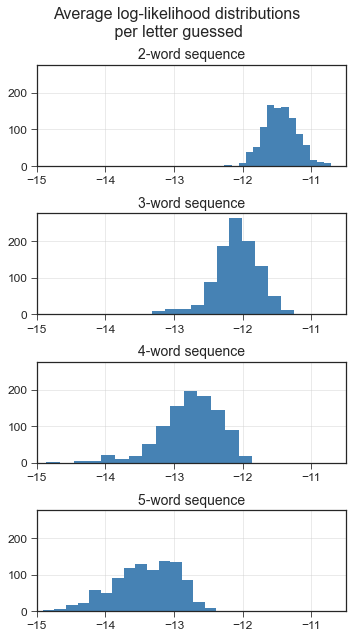

In [263]:
fig, ax = plt.subplots(nrows=4, sharey=True)
for i, num in enumerate(['2', '3', '4', '5']):
    ax[i].hist(lldf['mean_tll'+num], bins=15, color='steelblue')
    ax[i].set_title(f'{num}-word sequence', fontsize=14)
    ax[i].set_xlim((-15, -10.5))
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].grid(alpha=0.5)
fig.set_size_inches((5, 9))
fig.suptitle('Average log-likelihood distributions\n per letter guessed', fontsize=16)
# fig.supylabel('count', fontsize=12)

fig.tight_layout()
